## 02 - Visualization & Cleaning
In this notebook, we will visualize and further investigate the datasets processed in the ``01-Processing`` notebook in order to draw some more detailed insights regarding the characteristics of the data as it relates to our goal of predicting the market value of Jazz albums. 

## Setting up Colab Environment if in Colab
A key component of the processing of our data will involve the dimensionality reduction of the high-level features of the image data we have obtained using the pre-trained MobileNetV2 Model introduced in the previous notebook. Due to the high dimensionality and cardinality of our data, and our choice of the UMAP algorithm as the dimensionality reduction tool of choice in this project, we will make use of the RAPIDS AI CUML library (https://docs.rapids.ai/api), which provides a sci-kit learn-like API for implementations of machine learning algorithms that are specifically configured to run on GPU hardware. Using this library will significantly speed up the computation time associated with the dimensionality reduction we conduct towards the end of this notebook.

As I do not personally have access to a GPU, the GPU-enabled part of this notebook is run on Google's Colab Notebook environment, which offers GPU access for free. In the cell belows below, we define the functions required to setup a 25GB RAM Colab Notebook Environment with the packages necessary for the code to function.

In [ ]:
def upgrade_runtime_ram():
    """Crash the Colab Runtime if in a low RAM environment. This prompts an upgrade to a high RAM runtime.
    """
    meminfo = subprocess.getoutput('cat /proc/meminfo').split('\n')

    memory_info = {entry.split(':')[0]: int(entry.split(':')[1].replace(' kB','').strip()) for entry in meminfo}

    if memory_info['MemTotal'] > 17000000:
        return

    a = []
    while(1):
        a.append('1')

In [ ]:
def restart_runtime():
    """Restart the Colab Runtime
    """
    os.kill(os.getpid(), 9)

In [ ]:
def setup_rapids():
    """Sets up RAPIDS for Colab by testing the Runtime for compatibility and downloading and update RAPIDS packages and dependencies
    """
    def test_runtime_compatibility():
        """Test whether RAPIDS can be run on the given Colab Runtime. Restarts the Runtime if RAPIDS can not be run.
        """
        import pynvml
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        device_name = pynvml.nvmlDeviceGetName(handle)
        if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
            print("Wrong GPU - Restarting Runtime")
            restart_runtime()
            
    def download_and_update_rapids():
        # clone RAPIDS AI rapidsai-csp-utils scripts repo
        !git clone https://github.com/rapidsai/rapidsai-csp-utils.git

        # install RAPIDS
        !bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13

        # set necessary environment variables 
        dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
        sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
        sys.path

        # update pyarrow & modules 
        exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())
        
    test_runtime_compatibility()
    download_and_update_rapids()

In [ ]:
def setup_conda():
    if not 'Miniconda3-4.5.4-Linux-x86_64.sh' in os.listdir():
        !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

    if not ('EPFL-Capstone-Project' in os.listdir()) and (os.getcwd().split('/')[-1] != 'EPFL-Capstone-Project'):
        !git clone https://github.com/helmigsimon/EPFL-Capstone-Project  
    if 'EPFL-Capstone-Project' in os.listdir():
        os.chdir('EPFL-Capstone-Project')

    !conda env create -f environment.yml
    !conda activate exts-ml

In [ ]:
def setup_drive():
    #Mounting Google Drive
    global drive
    from google.colab import drive
    drive.mount('/content/drive')

In [6]:
try:
    import sys,os,subprocess
    
    upgrade_runtime_ram()
    setup_drive()

    #Setting up PyPi Packages
    !pip install geopandas sparse-dot-topn pdpipe category-encoders catboost
    import geopandas as gpd
    import sparse_dot_topn.sparse_dot_topn as ct
    import pdpipe as pdp
    import category_encoders

    #Setting up Conda Packages
    setup_conda()
    
    #Initializing NLTK
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    
    #Setting up RAPIDS AI
    #setup_rapids()
    import pynvml
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    device_name = pynvml.nvmlDeviceGetName(handle)
    if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
        print("Wrong GPU - Restarting Runtime")
        restart_runtime()

    # clone RAPIDS AI rapidsai-csp-utils scripts repo
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git

    # install RAPIDS
    !bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13

    # set necessary environment variables 
    dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
    sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
    sys.path

    # update pyarrow & modules 
    exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

    from cuml import UMAP
    
except ModuleNotFoundError as e:
    print(e)
    print('Not in colab environment, continuing to run locally')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Solving environment: failed

ResolvePackageNotFound: 
  - psycopg2==2.8.4=py36hafa8578_1
  - openssl==1.1.1f=h0b31af3_0
  - libgdal==3.0.4=hec54991_3
  - kealib==1.4.12=h2324030_0
  - proj==6.3.1=h773a61f_1
  - tzcode==2019a=h01d97ff_1002
  - libdap4==3.20.4=habf5908_0
  - matplotlib-base==3.2.0=py36h11da6c2_1
  - cfitsio==3.470=h84d2f63_2
  - statsmodels==0.11.1=py36h37b9a7d_1
  - cryptography==2.8=py36hc9d8292_2
  - geotiff==1.5.1=h4bdff65_9
  - gettext==0.19.8.1=h46ab8bc_1002
  - xerces-c==3.2.2=h8f8adb3_1004
  - grpcio==1.23.0=py36h7c1f37e_1
  - fontconfig==2.13.1=h6b1039f_1001
  - libpng==1.6.37=hbbe82c9_1
  - geos==3.8.1=h4a8c4bd_0
  - scipy==1.4.1=py36h82752d6_0
  - shapely==1.7.0=py36hda0b814_2
  - json-c==0.13.1=h1de35cc_1001
  - libprotobuf==3.11.4=hd174df1_0
  - krb5==1.16.4=h1752a42_0
  - tk==8.6.10=hbbe82c9_0
  - pcre==8.44=h4a8c4bd_0
  - icu==64.2=h6de7cb9_1
  - c-ares==1.15.0=h01d97ff_1001
  - zlib==1.2.11=h0b31af3_1006
  - nodejs==13.10.1=h38d8c5a_0
  - freexl==1.0.5=h1

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import pickle
import random
import umap
from tqdm import tqdm
from data.util.paths import DATA_PATH
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from lib.transformers import *
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
tqdm.pandas()

In [4]:
from lib.processing import *
from lib.pipelines import *
from data.scripts.project_data import DataLoader
from data.util.environment_variables import COUNTRY_CODES, M49_TO_ISO3

## Setting up Dataset

As a first step, we load the datasets that original ``extracted_data`` and ``api_data`` datasets, apply the pipelines outlined in the previous notebook, and merge them to create our core dataset, referred to henceforth as ``df``.

In [5]:
extracted_df, api_df = load_from_pkl('extracted',path=DATA_PATH), load_from_pkl('api',path=DATA_PATH)
extracted_df = extracted_pipe.fit_transform(extracted_df)
api_df = api_pipe.fit_transform(api_df)

In [6]:
df = pd.merge(extracted_df,api_df,on='release_id')

In [7]:
del extracted_df, api_df

## Create Column Store

In order to keep tabs on all of the subgroups of features that we are using in this project, we make use of the ``ColumnStore`` object, which uses the blueprint provided by the ``col_set`` variable to create a directory of column sets associated with our core dataset, ``df``. The ``ColumnStore`` object accepts strings which it matches with the column names it finds, collections of strings, which it saves as the columns associated with a given group, or functions, which it applies to the dataframe on the column axis to identify whether a given column belongs to the grouping or not.

In [8]:
col_set = {
    'format': {
        'description': 'format_description_', 
        'name': 'format_name_', 
        'text': ('format_text_clean'),
        'quantity': ('format_quantity')
    },
    'geography': {
        'superregion': 'superregion_',
        'region': 'region_',
        'country': 'country_'
    },
    'timeperiod': {
        'period': 'period_',
        'era': 'era_'
    },
    'genre': 'genre_',
    'style': 'style_',
    'null': None,
    'indicator': lambda x: x.max() == 1 and x.min() == 0,
}

In [9]:
column_store = ColumnStore()
column_store.fit(df,col_set)

## Overview of Number of Albums over Time
As an initial step to gain an overview of the development of the release of Jazz albums over the time period we are dealing with, we will plot this in a line plot, and superimpose the eras and periods associated with the time periods.

In [10]:
period_year_range, era_year_range = make_year_range_dict(column_store._timeperiod_period,df=df), make_year_range_dict(column_store._timeperiod_era,df=df)
time_period_year_range = dict(**period_year_range,**era_year_range)

In [11]:
year_count_series = df.groupby(by='year')['market_value'].count()
year_count_series[1936] = 0
year_count_series.sort_index(inplace=True)

In [12]:
period_colors = {
    'period_big_band': 'red',
    'period_bebop': 'pink',
    'period_cool': 'blue',
    'period_fusion': 'orange',
}
era_colors = {
    'era_swing': 'purple',
    'era_modern': 'green',
    'era_contemporary': 'gold'
}
time_period_colors = dict(**period_colors,**era_colors)

In [13]:
def plot_variable_with_time_periods(year_series,time_periods,time_period_colors,**kwargs):
    plt.figure(figsize=(20,10))

    #Setting up plotting helpers
    dev_constant = 200
    convert_to_label = lambda x: ' '.join(x.split('_')).title()

    #Plotting
    plt.plot(year_series)
    for time_period, year_range in time_periods.items():
        if 'period' in time_period:
            try:
                min_, max_, hatch_ = 0, year_series.loc[year_range], '/'
            except KeyError:
                print(year_range)
        else:
            min_, max_, hatch_ = year_series.loc[year_range], year_series.loc[year_range]+dev_constant, None

        plt.fill_between(year_range,max_,min_,alpha=0.25,color=time_period_colors[time_period],hatch=hatch_,label=convert_to_label(time_period))
    
    for attr in (kwargs):
        try:
            getattr(plt,attr)(kwargs[attr])
        except Exception as e:
            print(e)
    
    plt.legend()
    plt.show()
    

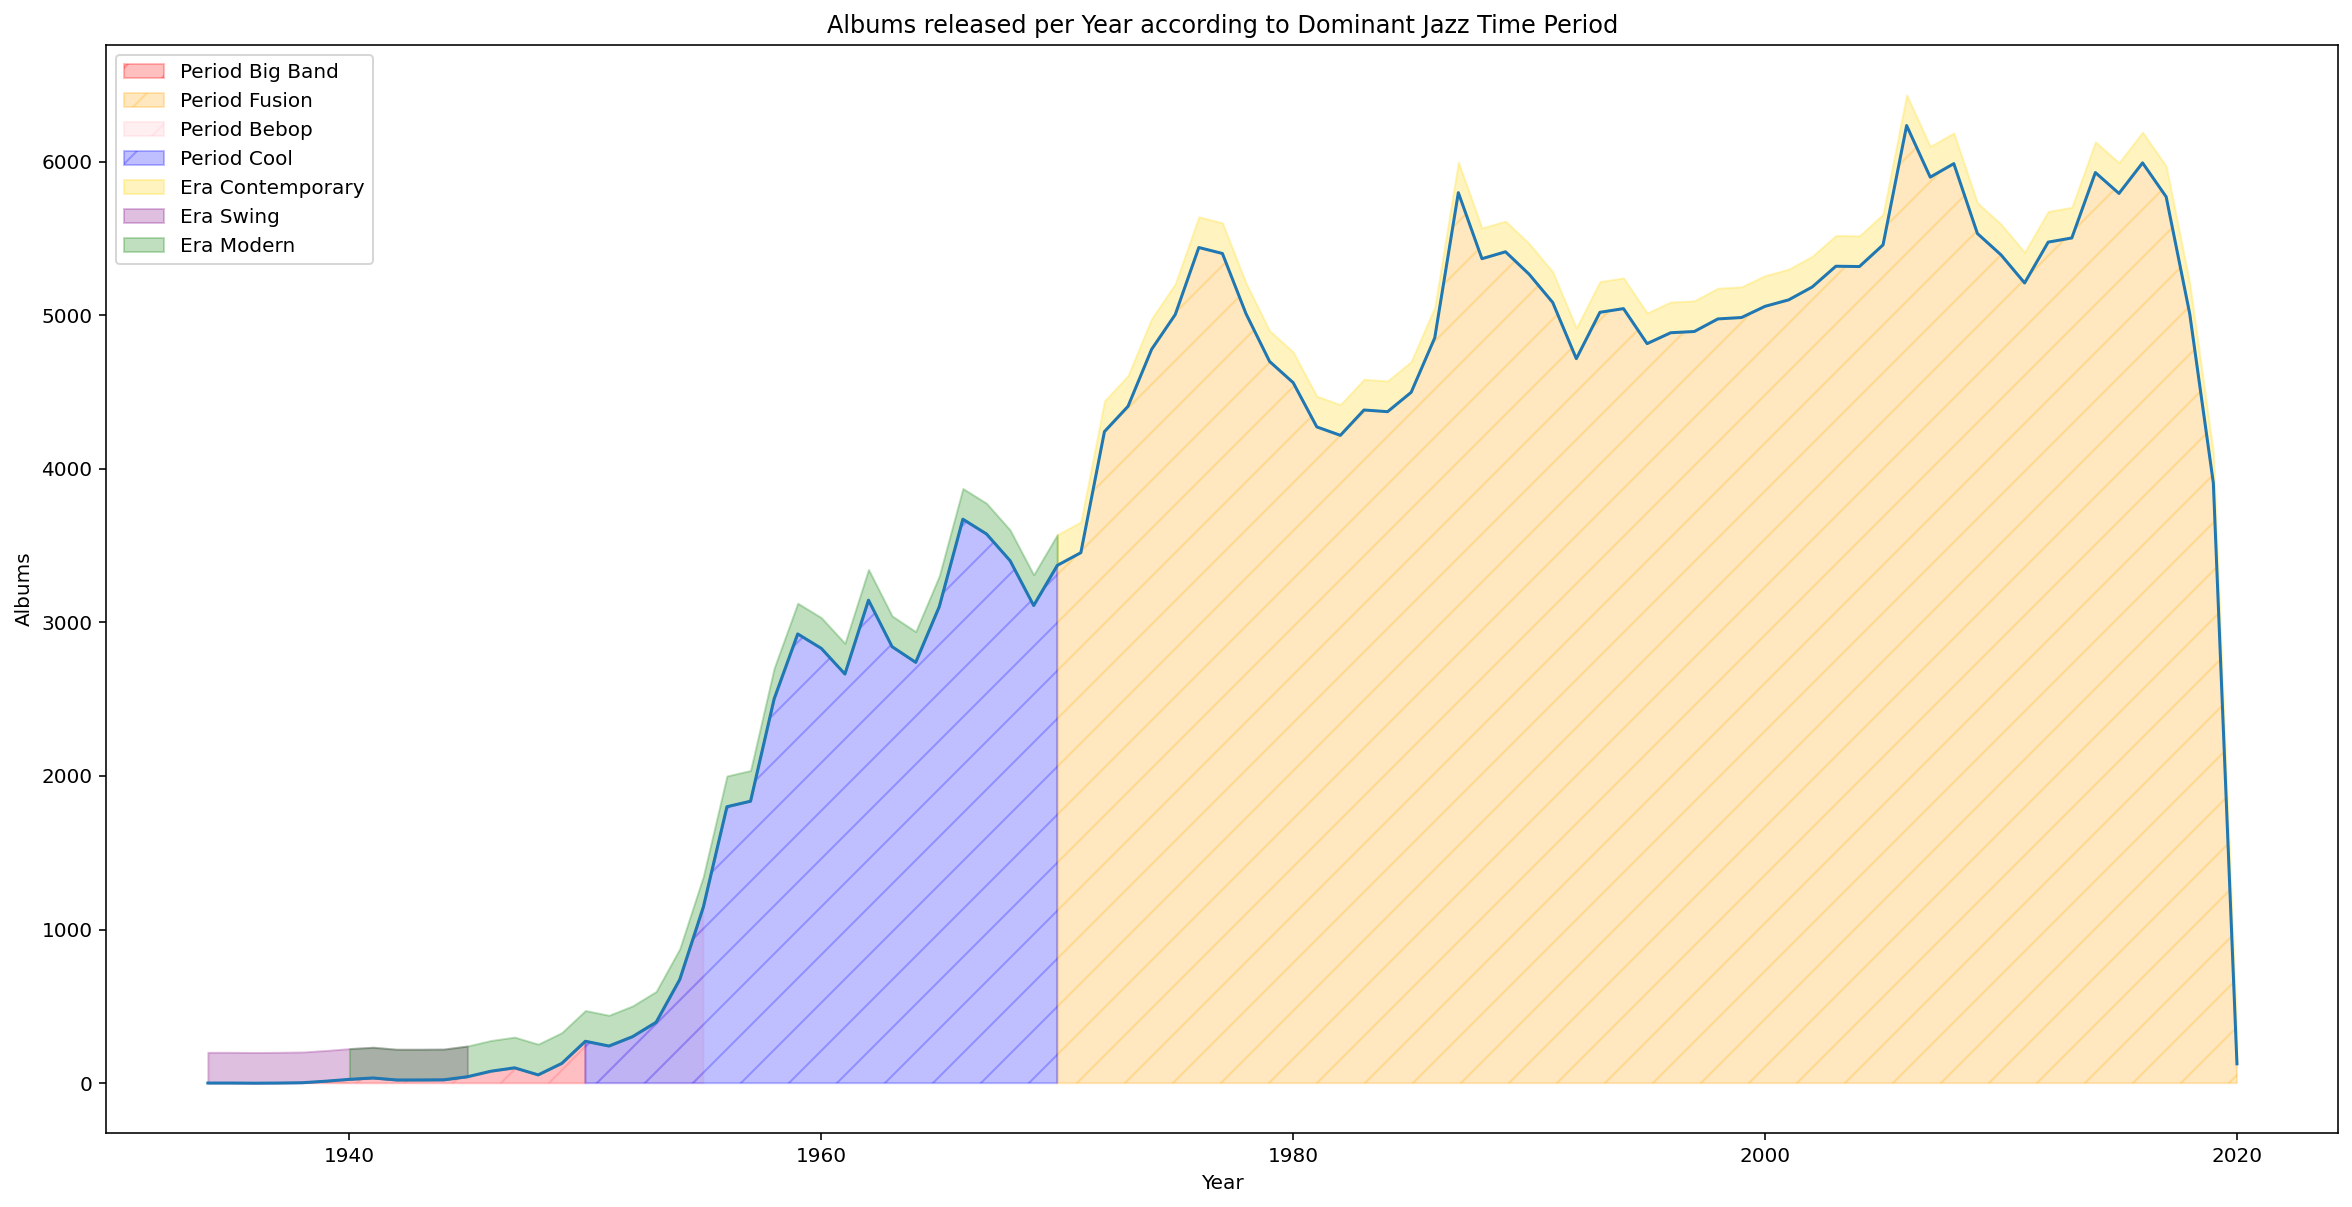

In [14]:
plot_variable_with_time_periods(year_count_series,
                                time_period_year_range,
                                time_period_colors,
                                xlabel='Year',
                                ylabel='Albums',
                                title='Albums released per Year according to Dominant Jazz Time Period')

As we can see from the above, there was a massive explosion in the number of Jazz albums released per year in the 1950s, with a cyclical rise through the rest of the 20th century and into the 21st. In the Contemporary Jazz Era/Jazz Fusion Period, we see that the number of Jazz albums released is at its highest. This could be due to the growing influence of Jazz on other music genres, and the heightened cross-pollination that has characterized music in the digital age. 
To further investigate this, we will limit the development of albums per year to those which are solely listed as Jazz albums, and do not have any other genres associated with them.

In [21]:
pure_jazz_album_count = df[df[column_store._genre].sum(axis=1)==0].groupby(by='year').count()['market_value']
pure_jazz_album_count[1934], pure_jazz_album_count[1936] = 0,0
pure_jazz_album_count.sort_index(inplace=True)

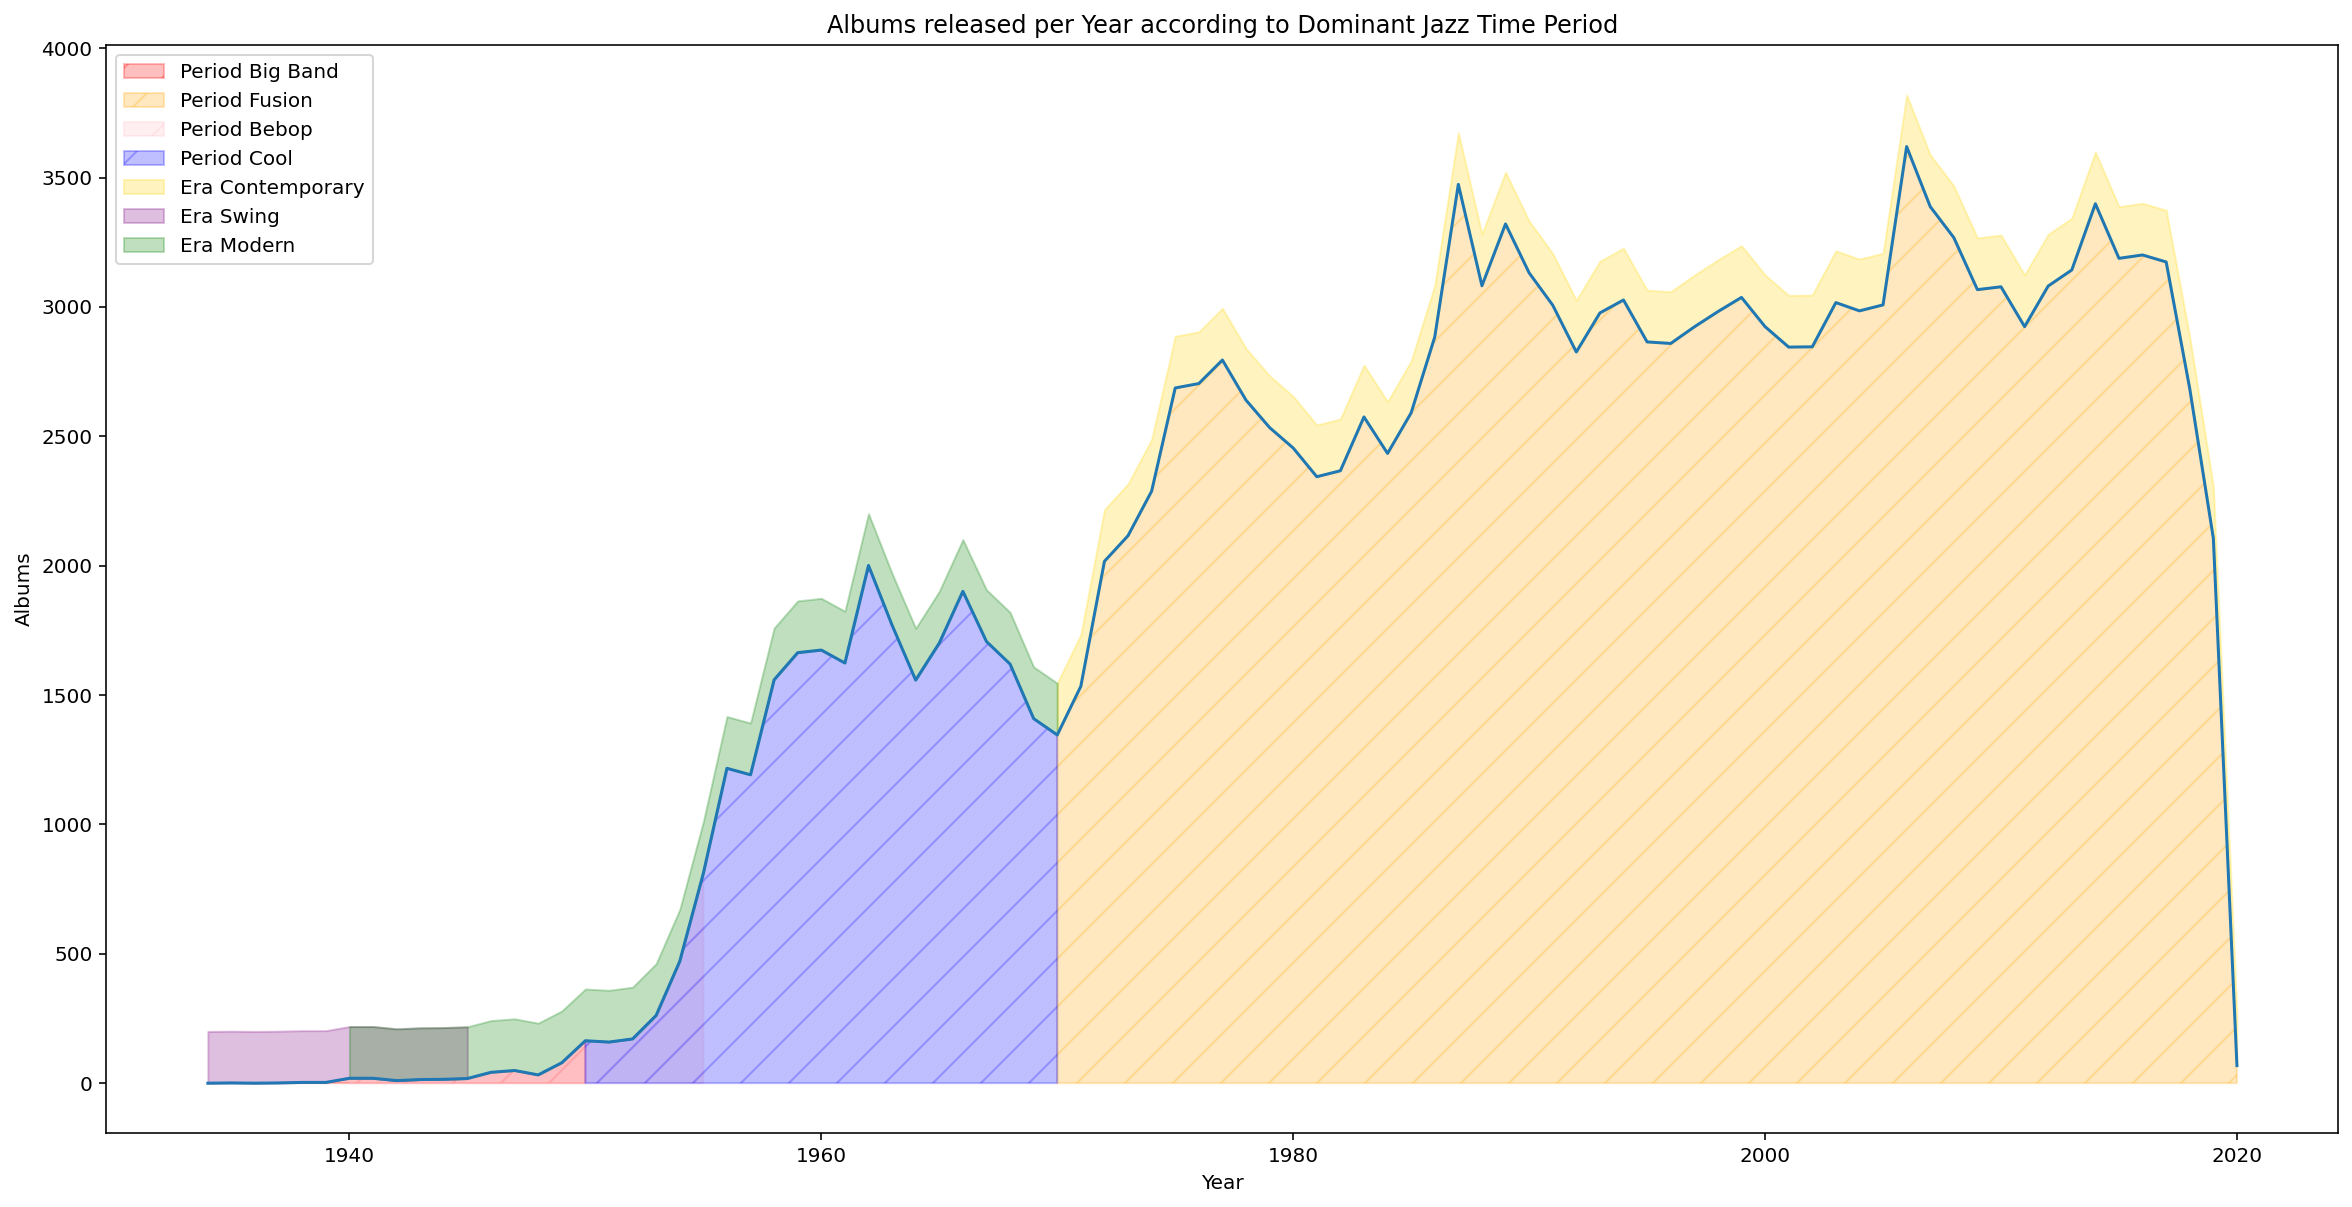

In [22]:
plot_variable_with_time_periods(pure_jazz_album_count,
                                time_period_year_range,
                                time_period_colors,
                                xlabel='Year',
                                ylabel='Albums',
                                title='Albums released per Year according to Dominant Jazz Time Period')

As we can see, the trend of the figure above is effectively identical to the one which includes non 'pure' Jazz albums, indicating that the rising trend in album releases is not primarily due to the incorporation of Jazz into other styles, but instead a growth of the music in its "purest" form over time.

## Market Value
Having established the development of our object of interest over the time period considered in this project, let us now turn our attention to the feature we are trying to predict, namely ``market_value``, and identify it's specificities. To do so, we will consider the distribution of the feature, it's evolution over time and it's correlations with the rest of our features
### Distribution

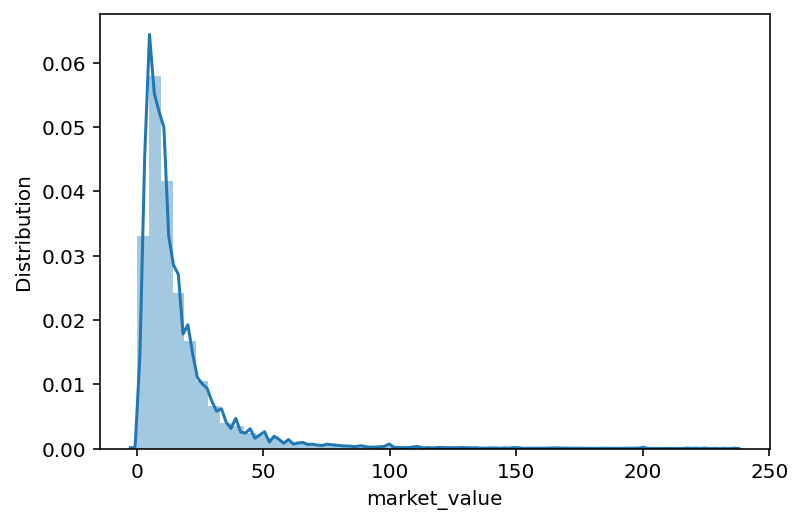

In [23]:
sns.distplot(df['market_value'])
plt.ylabel('Distribution')
plt.show()

From the above we see that there is a substantial leftward skew for ``market_value``. Despite having initially removed outliers from the dataset we are considering using the ``OutlierRemover`` transformer in the ``extracted_pipe`` pipeline, we see that outliers continue to distort the distribution of our target variable.

Given the leftward skew of our target feature, we can log-linearize the variable in order to obtain a more Gaussian distribution of ``market_value``, which is commonly recommended as a means to improve algorithmic performance.

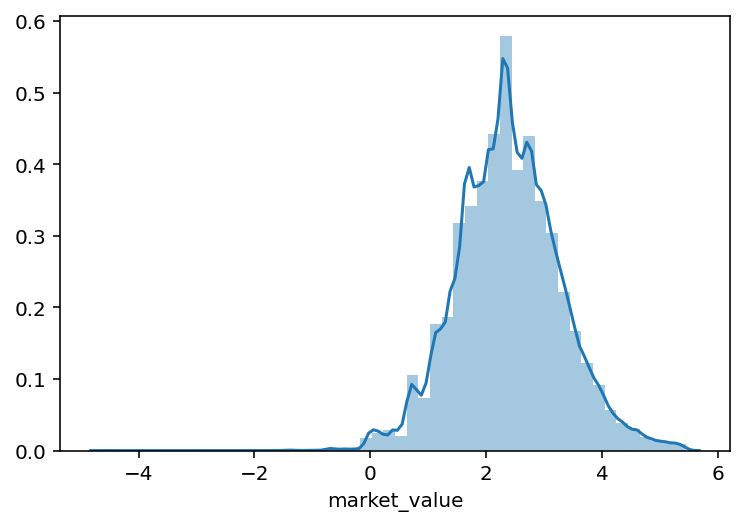

In [24]:
sns.distplot(np.log(df['market_value']));

## Evolution of Market Value over Time

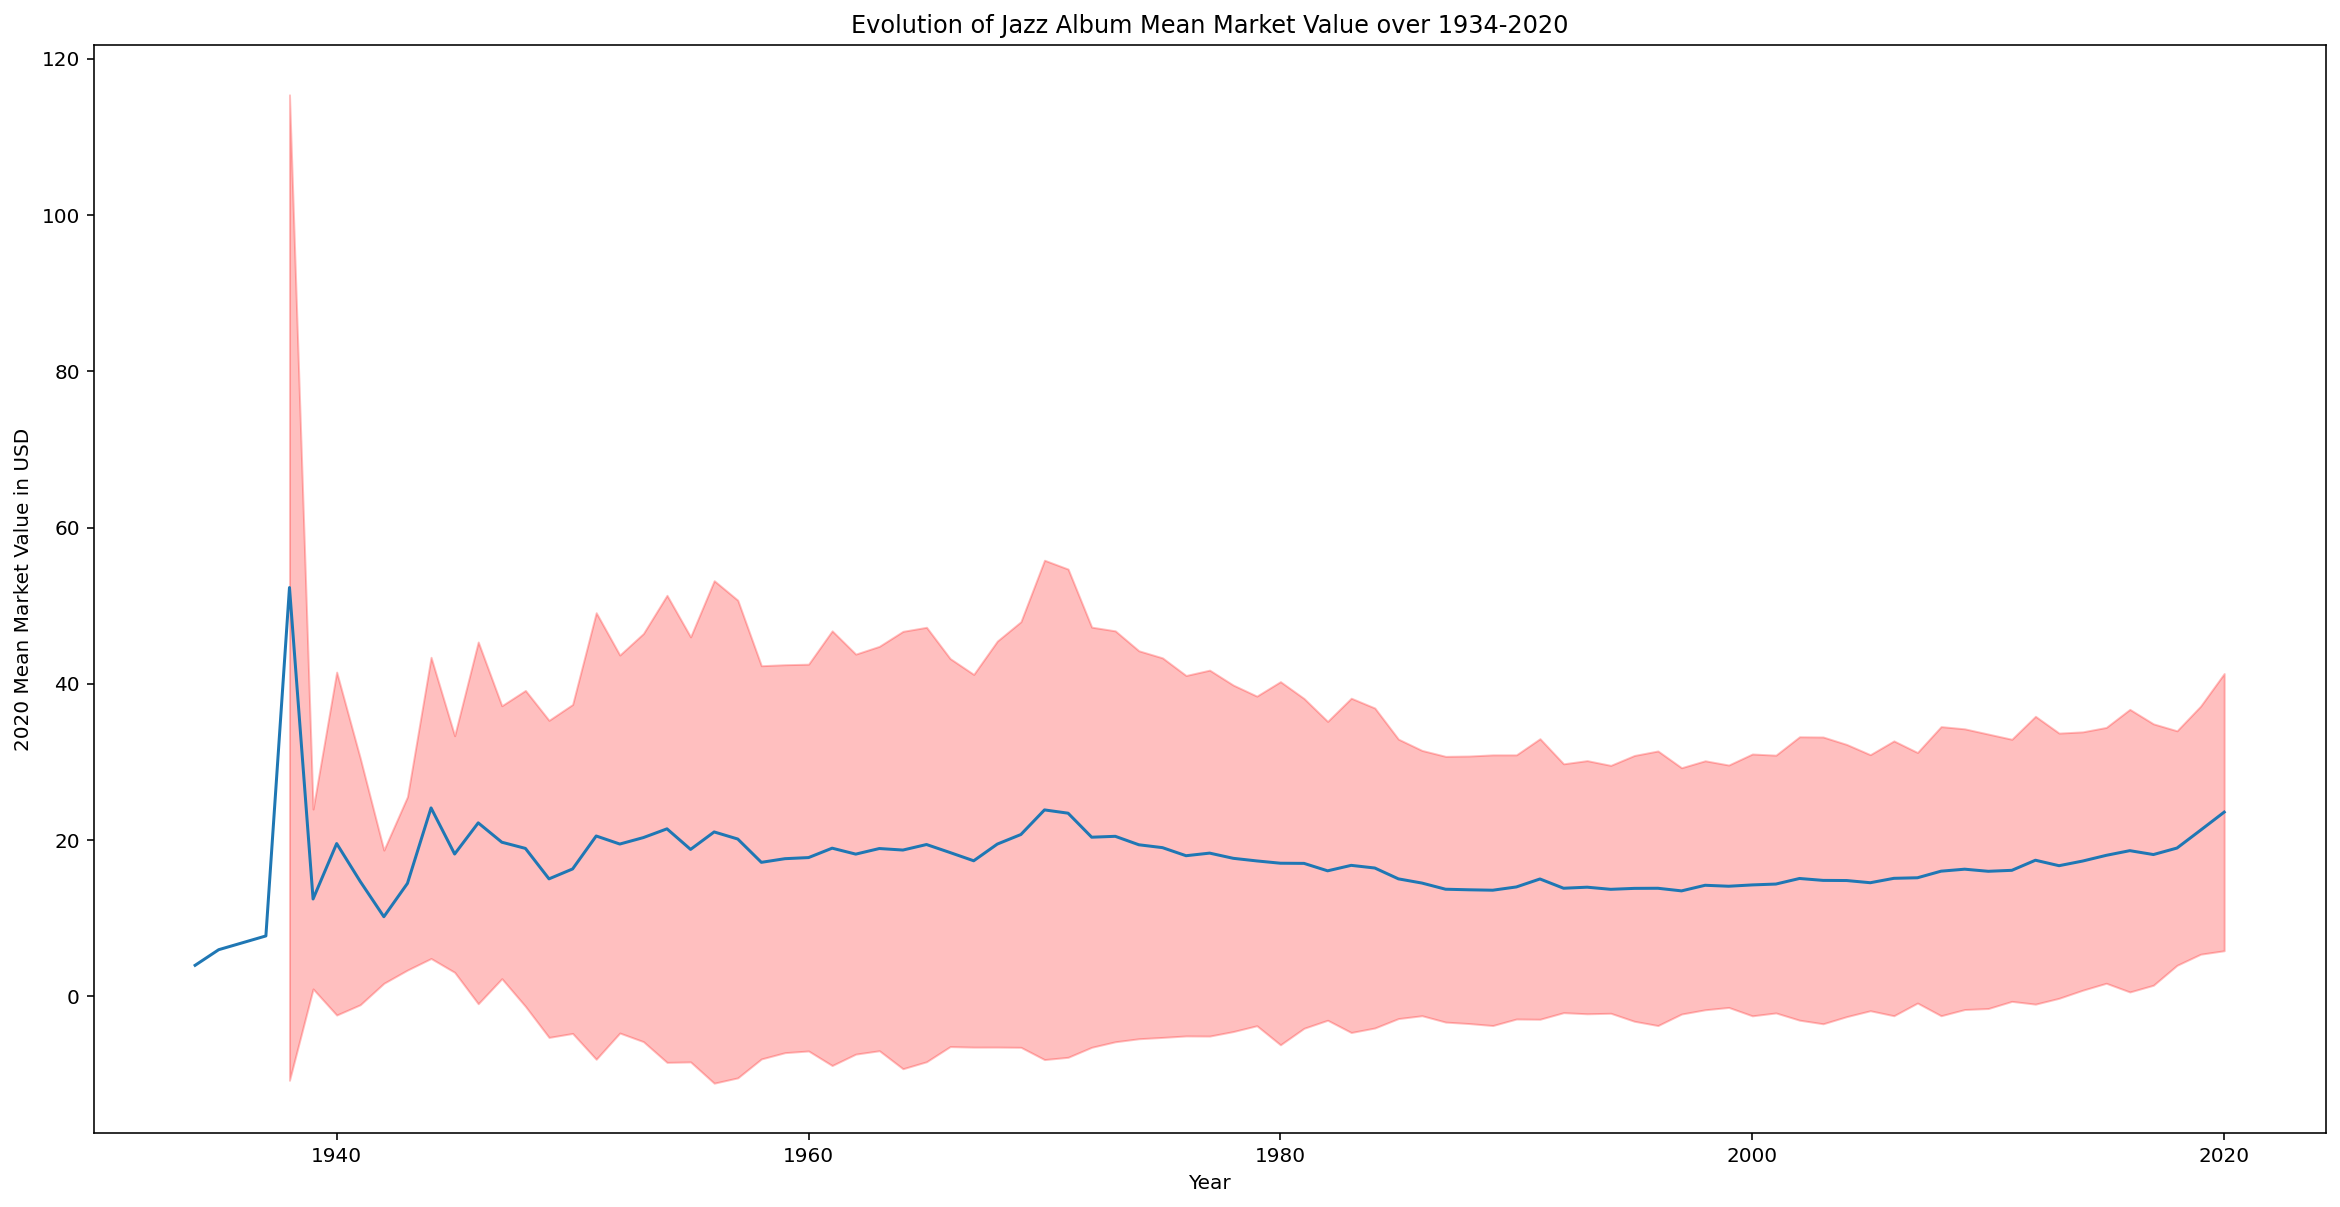

In [25]:
plt.figure(figsize=(20,10))
plt.title('Evolution of Jazz Album Mean Market Value over 1934-2020')
plt.xlabel('Year')
plt.ylabel('2020 Mean Market Value in USD')
plt.plot(df.groupby(by='year')['market_value'].mean())
mean_value = df.groupby(by='year')['market_value'].mean()
std_error = df.groupby(by='year')['market_value'].std()
plt.fill_between(std_error.index, mean_value-std_error, mean_value+std_error, alpha=0.25,color='red')
plt.show()

From the above, we see that even after removing the most offending outliers, there is still tremendous variation in the price of Jazz records, which is particularly large in the mid 20th century, and slowly reduces over time, but never to a very small margin.

Let us take a closer look into the breakdown of this progression in ``market_value`` over the years

In [26]:
df.groupby('year')['market_value'].describe().head(25)

count       mean        std        min        25%        50%  \
year                                                                  
1934     1.0   3.990000        NaN   3.990000   3.990000   3.990000   
1935     1.0   5.990000        NaN   5.990000   5.990000   5.990000   
1937     1.0   7.750000        NaN   7.750000   7.750000   7.750000   
1938     3.0  52.333333  63.058174  12.000000  16.000000  20.000000   
1939    13.0  12.477614  11.509323   4.720000   5.550000   8.700000   
1940    25.0  19.572000  21.945552   2.000000   5.300000  12.500000   
1941    34.0  14.719412  15.772849   2.750000   5.775000   9.450000   
1942    21.0  10.209848   8.522345   2.000000   4.950000   6.990000   
1943    21.0  14.478304  11.093569   1.950000   5.550000  11.840000   
1944    22.0  24.136172  19.274118   2.500000  10.328199  24.810000   
1945    42.0  18.232619  15.138746   1.000000   9.000000  11.000000   
1946    78.0  22.220737  23.148604   1.000000   6.750000  15.445000   
1947   100.0  19.744576  17.464514   1.000000   6.500000  14.870000   
1948    54.0  18.952407  20.213476   1.000000   5.992500  10.900000   
1949   129.0  15.053591  20.288380   0.800000   5.000000   8.060000   
1950   273.0  16.322870  21.050248   0.936667   4.990000   9.200000   
1951   242.0  20.541537  28.575032   0.392093   5.935856  10.625000   
1952   303.0  19.510249  24.185595   0.250000   5.625000  10.782564   
1953   397.0  20.337587  26.112990   0.250000   6.410000  11.990000   
1954   675.0  21.456062  29.885690   0.490117   5.000000  11.240000   
1955  1147.0  18.824174  27.196500   0.250000   5.000000   9.880000   
1956  1800.0  21.059270  32.152680   0.450000   5.060000  10.450000   
1957  1836.0  20.151754  30.563635   0.010000   4.950000   9.990000   
1958  2502.0  17.169594  25.161163   0.010000   4.657500   8.970000   
1959  2925.0  17.636177  24.823762   0.250000   4.910000   9.500000   

            75%         max  
year                         
1934   3.990000    3.990000  
1935   5.990000    5.990000  
1937   7.750000    7.750000  
1938  72.500000  125.000000  
1939  11.370703   40.250000  
1940  28.000000  100.000000  
1941  15.750000   83.060000  
1942  10.000000   34.000000  
1943  18.470000   41.884382  
1944  32.627500   87.780000  
1945  24.990000   60.000000  
1946  24.997500  111.110000  
1947  28.335000   76.470000  
1948  24.997500  112.500000  
1949  16.610000  169.990000  
1950  20.000000  150.000000  
1951  19.997500  192.270000  
1952  22.230000  200.000000  
1953  22.580000  194.870000  
1954  23.975180  225.000000  
1955  20.480000  230.000000  
1956  21.501282  235.386631  
1957  21.000000  228.721046  
1958  18.977500  229.864652  
1959  19.604661  204.880000

The data extract above provides a more detailed look at the development of ``market_value`` and the number of Jazz Albums released per year over the considered time period. As we saw in the previous visualization, the mean of ``market_value`` starts very low, and gradually rises to a level that it remains fairly constant at in the late 1940s, which is between around 15 and 20 USD for a Jazz album.

Given the more fine-grained look at the development of ``market_value`` and the very low number of entries per year towards the start of the time period considered in this project, we will choose to disregard those albums released before 1950, as there are relatively few releases from this period, and it is unlikely that the information learned from this era will generalize well to the time period in which most Jazz albums have been released, which begins around 1950.

In [27]:
record_reduction_pre_1950 = len(df)-len(df[df['year']>1949])
print('Number of rows removed by changing focus to years after 1950: {} ({}%)'.format(record_reduction_pre_1950,np.round(100*record_reduction_pre_1950/len(df),decimals=2)))
print('Number of columns removed by changing focus to years after 1950: {}'.format(1951-1934))

Number of rows removed by changing focus to years after 1950: 545 (0.18%)
Number of columns removed by changing focus to years after 1950: 17


The above results in a minor reduction in the cardinality of the model, around 0.18% of the total data, while reducing the number of additional indicator variables, and the corresponding dimensionality required by the model, by 17 features, as the one-hot encoding we will later apply to the ``year`` feature will result in less columns.

## Correlations 
As a next step, we will visualize the correlations between the core non-categorical attributes and the ``market_value`` target feature, in order to get an understanding of how strong the relationship between our predictor and target features are. 

In [28]:
pairplot_columns = list(filter(lambda x: df[x].dtype in (float,int) and x not in ['master_id','have','want','median','release_id','market_value'],column_store._rest))

In [29]:
def plot_correlation_subplots(df, var, var_list,nrows,ncols,figsize=(60,60)):
    
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)

    for row_idx, row in enumerate(ax):
        for col_idx, col in enumerate(row):
            row_modifier = len(var_list)-ncols*row_idx
            list_idx = len(var_list)-row_modifier+col_idx
            col_column = var_list[list_idx]
            col.set_title(col_column,fontdict={'fontsize':50})
            col.scatter(df[col_column],df[var],edgecolor='white')
    plt.show()

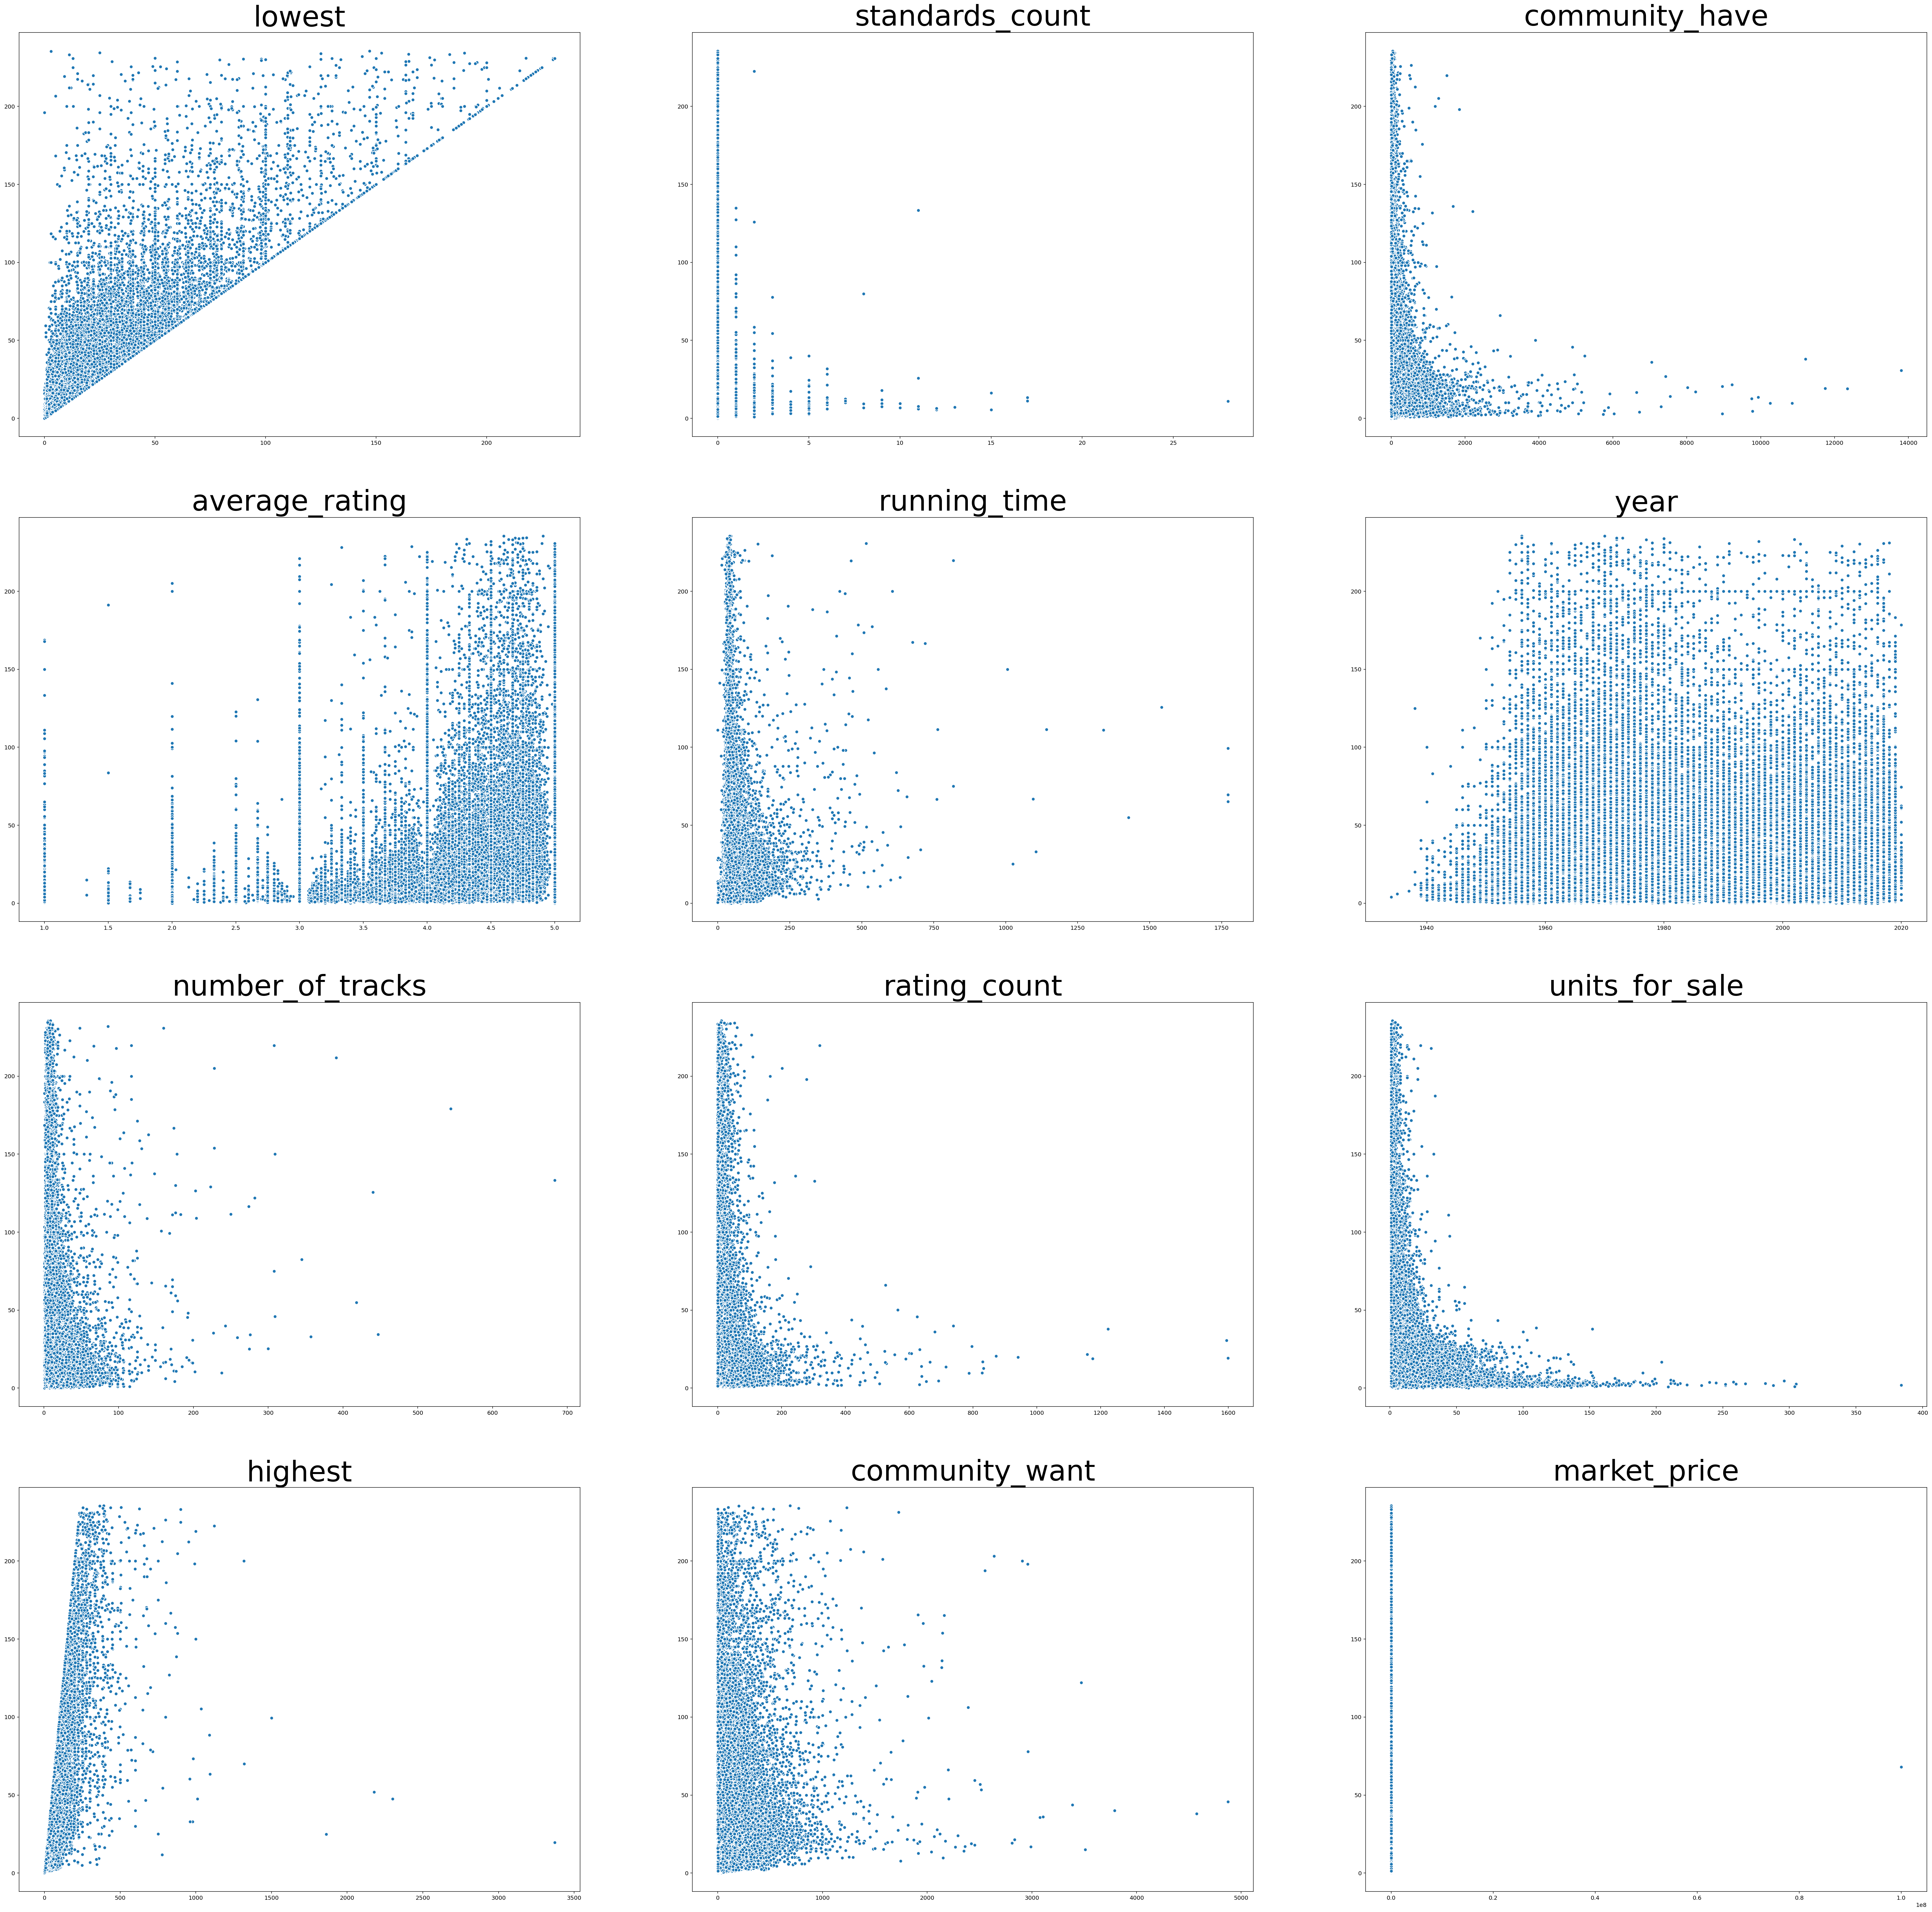

In [30]:
plot_correlation_subplots(df,'market_value',pairplot_columns,4,3)

As we can see from the plots above, there are not many clear relationships that can be identified between the ``market_value`` feature and the numerical features of the dataset. This implies that performance of the model will rely heavily on an efficient encoding of non-numerical features, such as ``genre``, ``style``, ``artist`` etc. in order to be able to predict the market value of a given record with any certainty.

To gain an insight into how crucial the indicator variables may be in the downstream prediction task, we will calculate the correlation coefficients of each indicator with respect to the ``market_value`` feature.

In [31]:
def get_correlation_series(df,correlation_column,columns=None):
    df = df.copy()
    
    if not columns:
        columns = df.columns
    
    return pd.Series({
        column: np.corrcoef(
            df[correlation_column].values,
            df[column].values
        )[0][1]
        for column in columns
    })

In [32]:
market_value_indicator_correlations = get_correlation_series(df,'market_value',column_store._indicator)

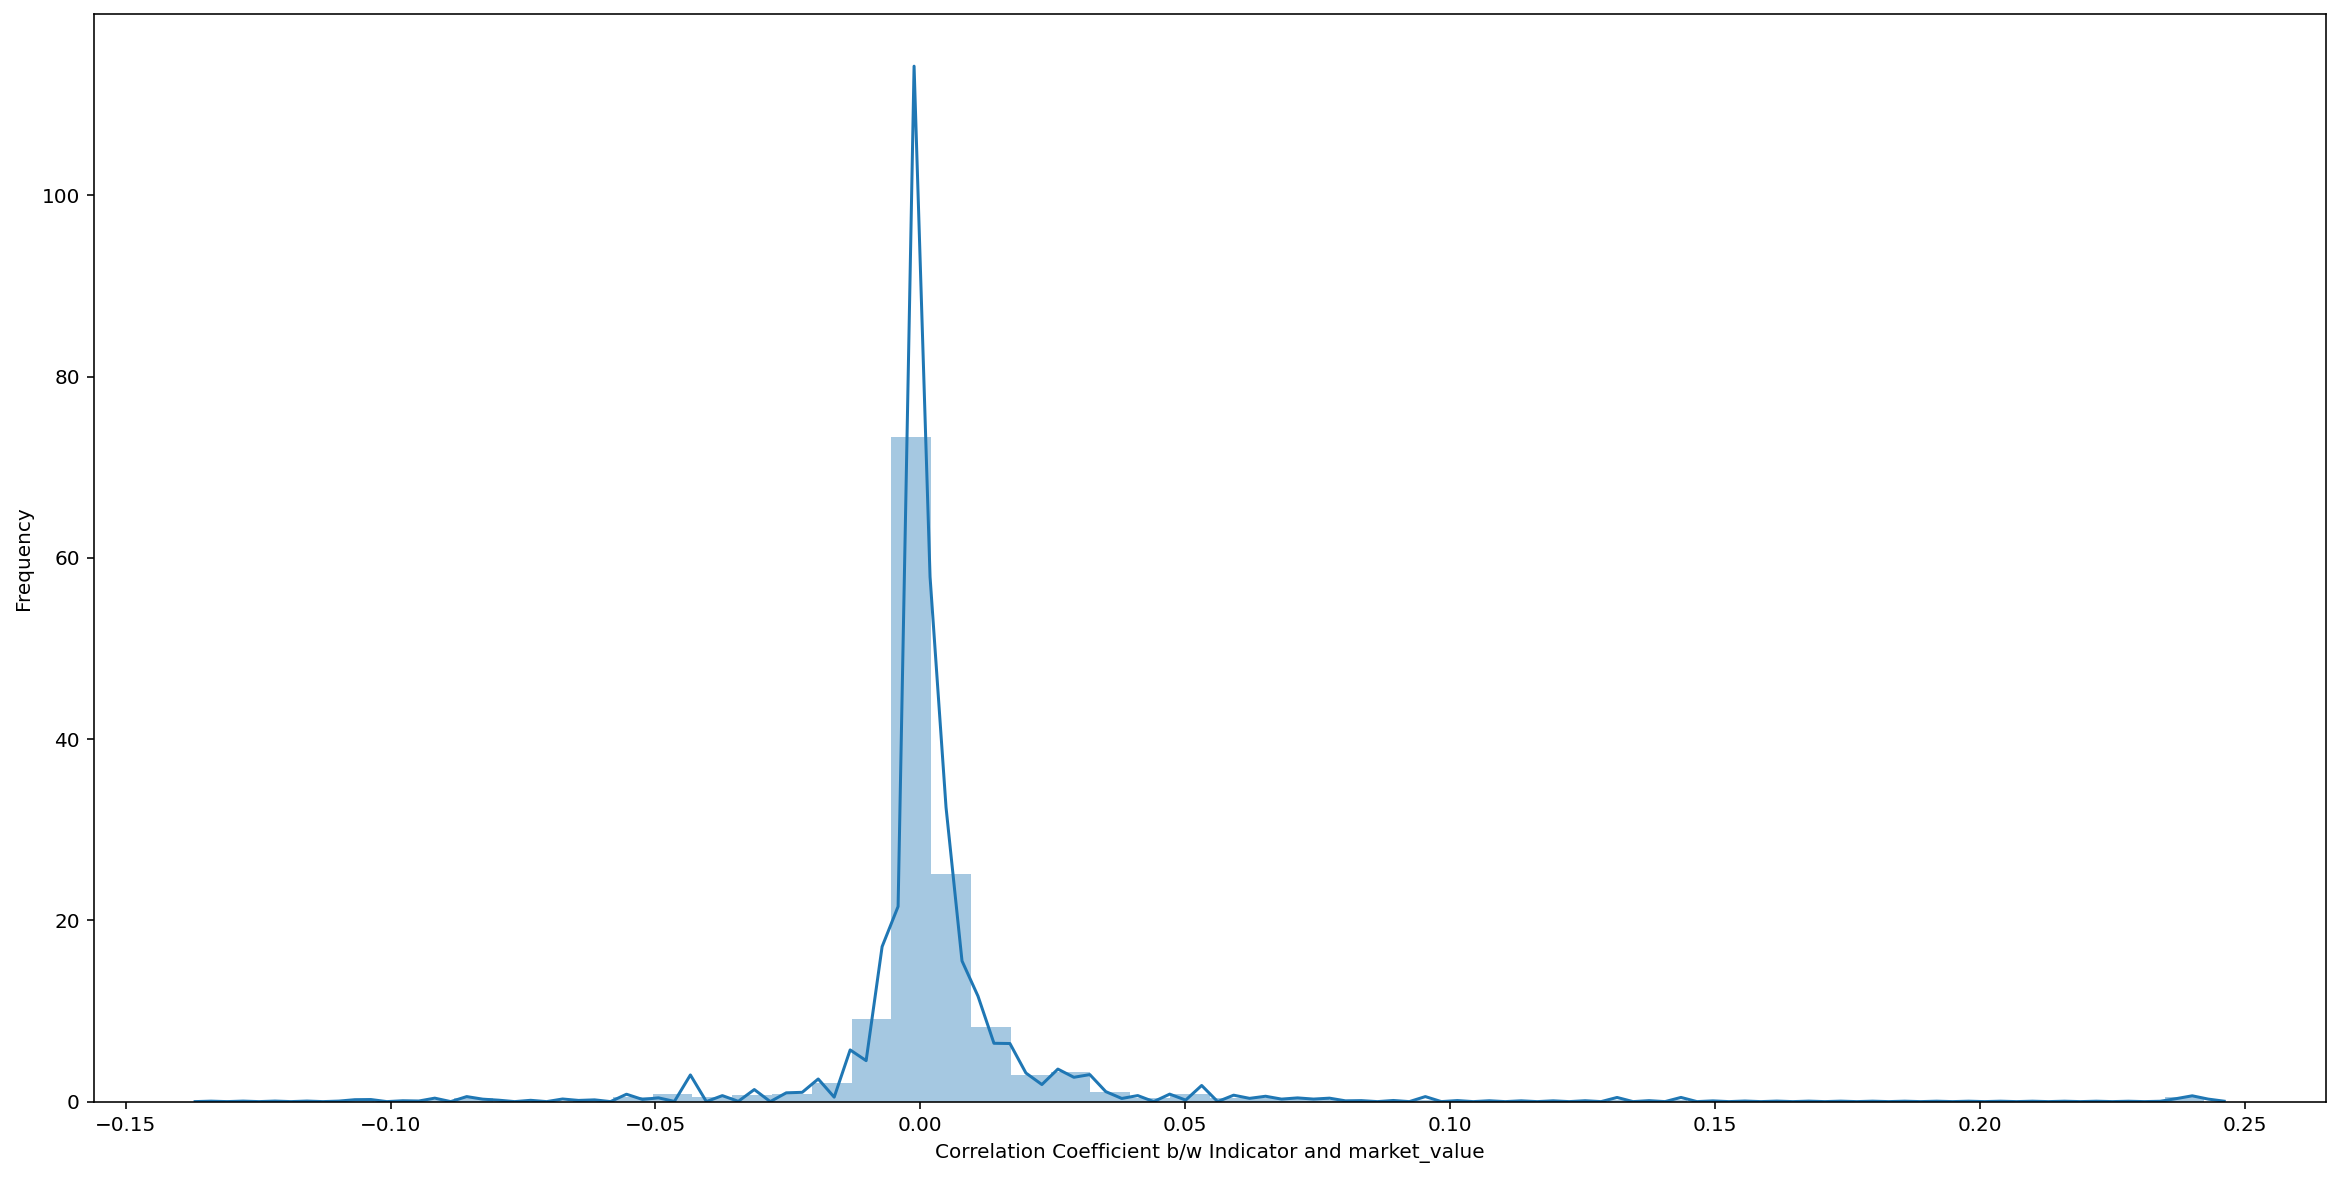

In [33]:
plt.figure(figsize=(20,10))
sns.distplot(market_value_indicator_correlations)
plt.ylabel('Frequency')
plt.xlabel('Correlation Coefficient b/w Indicator and market_value')
plt.show()

In [34]:
market_value_indicator_correlations.describe()

count    773.000000
mean       0.002650
std        0.022808
min       -0.133138
25%       -0.001705
50%       -0.000143
75%        0.004320
max        0.242364
dtype: float64

From the above, it is clear that on the whole, our indicator variables are not highly correlated with ``market_value`` either. The vast majority of indicator variables seem to have almost negligible correlations with ``market_value``, closely centred around zero, with only very few instances of stronger correlations. 

As a next step, we'll seek to identify and rationalize the strongest correlations of the coefficients we have calculated above.

In [35]:
sign = market_value_indicator_correlations.apply(lambda x: 'positive' if x >= 0 else 'negative')
market_value_indicator_correlations = pd.DataFrame(
    {'correlation': market_value_indicator_correlations.abs().values,'sign': sign.values},
    index = market_value_indicator_correlations.index
)

In [36]:
market_value_indicator_correlations.sort_values(by='correlation',ascending=False).head(25)

correlation      sign
region_eastern asia                        0.242364  positive
country_japan                              0.238826  positive
superregion_asia                           0.238735  positive
format_name_Vinyl                          0.144089  positive
format_name_CD                             0.133138  negative
format_description_Limited Edition         0.132093  positive
region_north america                       0.105639  negative
style_Hard Bop                             0.095435  positive
superregion_europe                         0.092869  negative
country_united states of america           0.085683  negative
superregion_americas                       0.082371  negative
format_description_Test Pressing           0.078588  positive
style_Modal                                0.074450  positive
format_description_Mono                    0.070163  positive
region_latin america and the caribbean     0.067090  positive
style_Easy Listening                       0.065418  negative
format_description_Numbered                0.064008  positive
country_brazil                             0.061967  positive
format_description_45 RPM                  0.059058  positive
country_canada                             0.056506  negative
genre_Pop                                  0.054363  negative
era_modern                                 0.053290  positive
period_cool                                0.053213  positive
style_Free Jazz                            0.053183  positive
format_name_Cassette                       0.052104  negative

As we can see by investigating the top correlations, albums from Japan in particular seem to be the most highly positively correlated with ``market_value``, followed by Limited Edition albums. An interesting takeaway is that albums from Europe and North America tend to be negatively correlated with price, which may be linked to their dominance in the genre and the sheer volume of albums they release. Additionally, we observe that albums in Vinyl format are one of the format indicators most strongly correlated with ``market_value``, and albums in CD format are most negatively correlated with the target feature. Furthermore, we see that the Hard Bop and Modal jazz styles tend to be the most positively correlated with ``market_value``, which is also understandable, given that these were the dominant styles during the modern jazz era, which to this day are styles of Jazz that continue to define the genre in the minds of the general public. 

Notice also, that other than Pop, genres are not highly represented in the dataset, and the style indicators which are most common throughout the top correlations are those associated with more 'pure' Jazz ('Hard Bop','Modal','Easy Listening','Free Jazz','Big Band'). We will discuss this in further detail in the next section.

## Indicators
Having investigated and visualized the ``market_value`` feature, we now move on to taking a closer look at the core indicator variables which we utilize to inject additional information into the machine learning models we will build shortly.
### Genres
The ``genre`` feature, as previously discussed, is one of the most well-behaved features of the dataset, in that it is standardized by Discogs.com and has a relatively low dimensionality after being encoded. We summarize the ``genre`` values attributed to the albums we consider in this study below

In [37]:
genre_sum = df[column_store._genre].sum().sort_values(ascending=False)

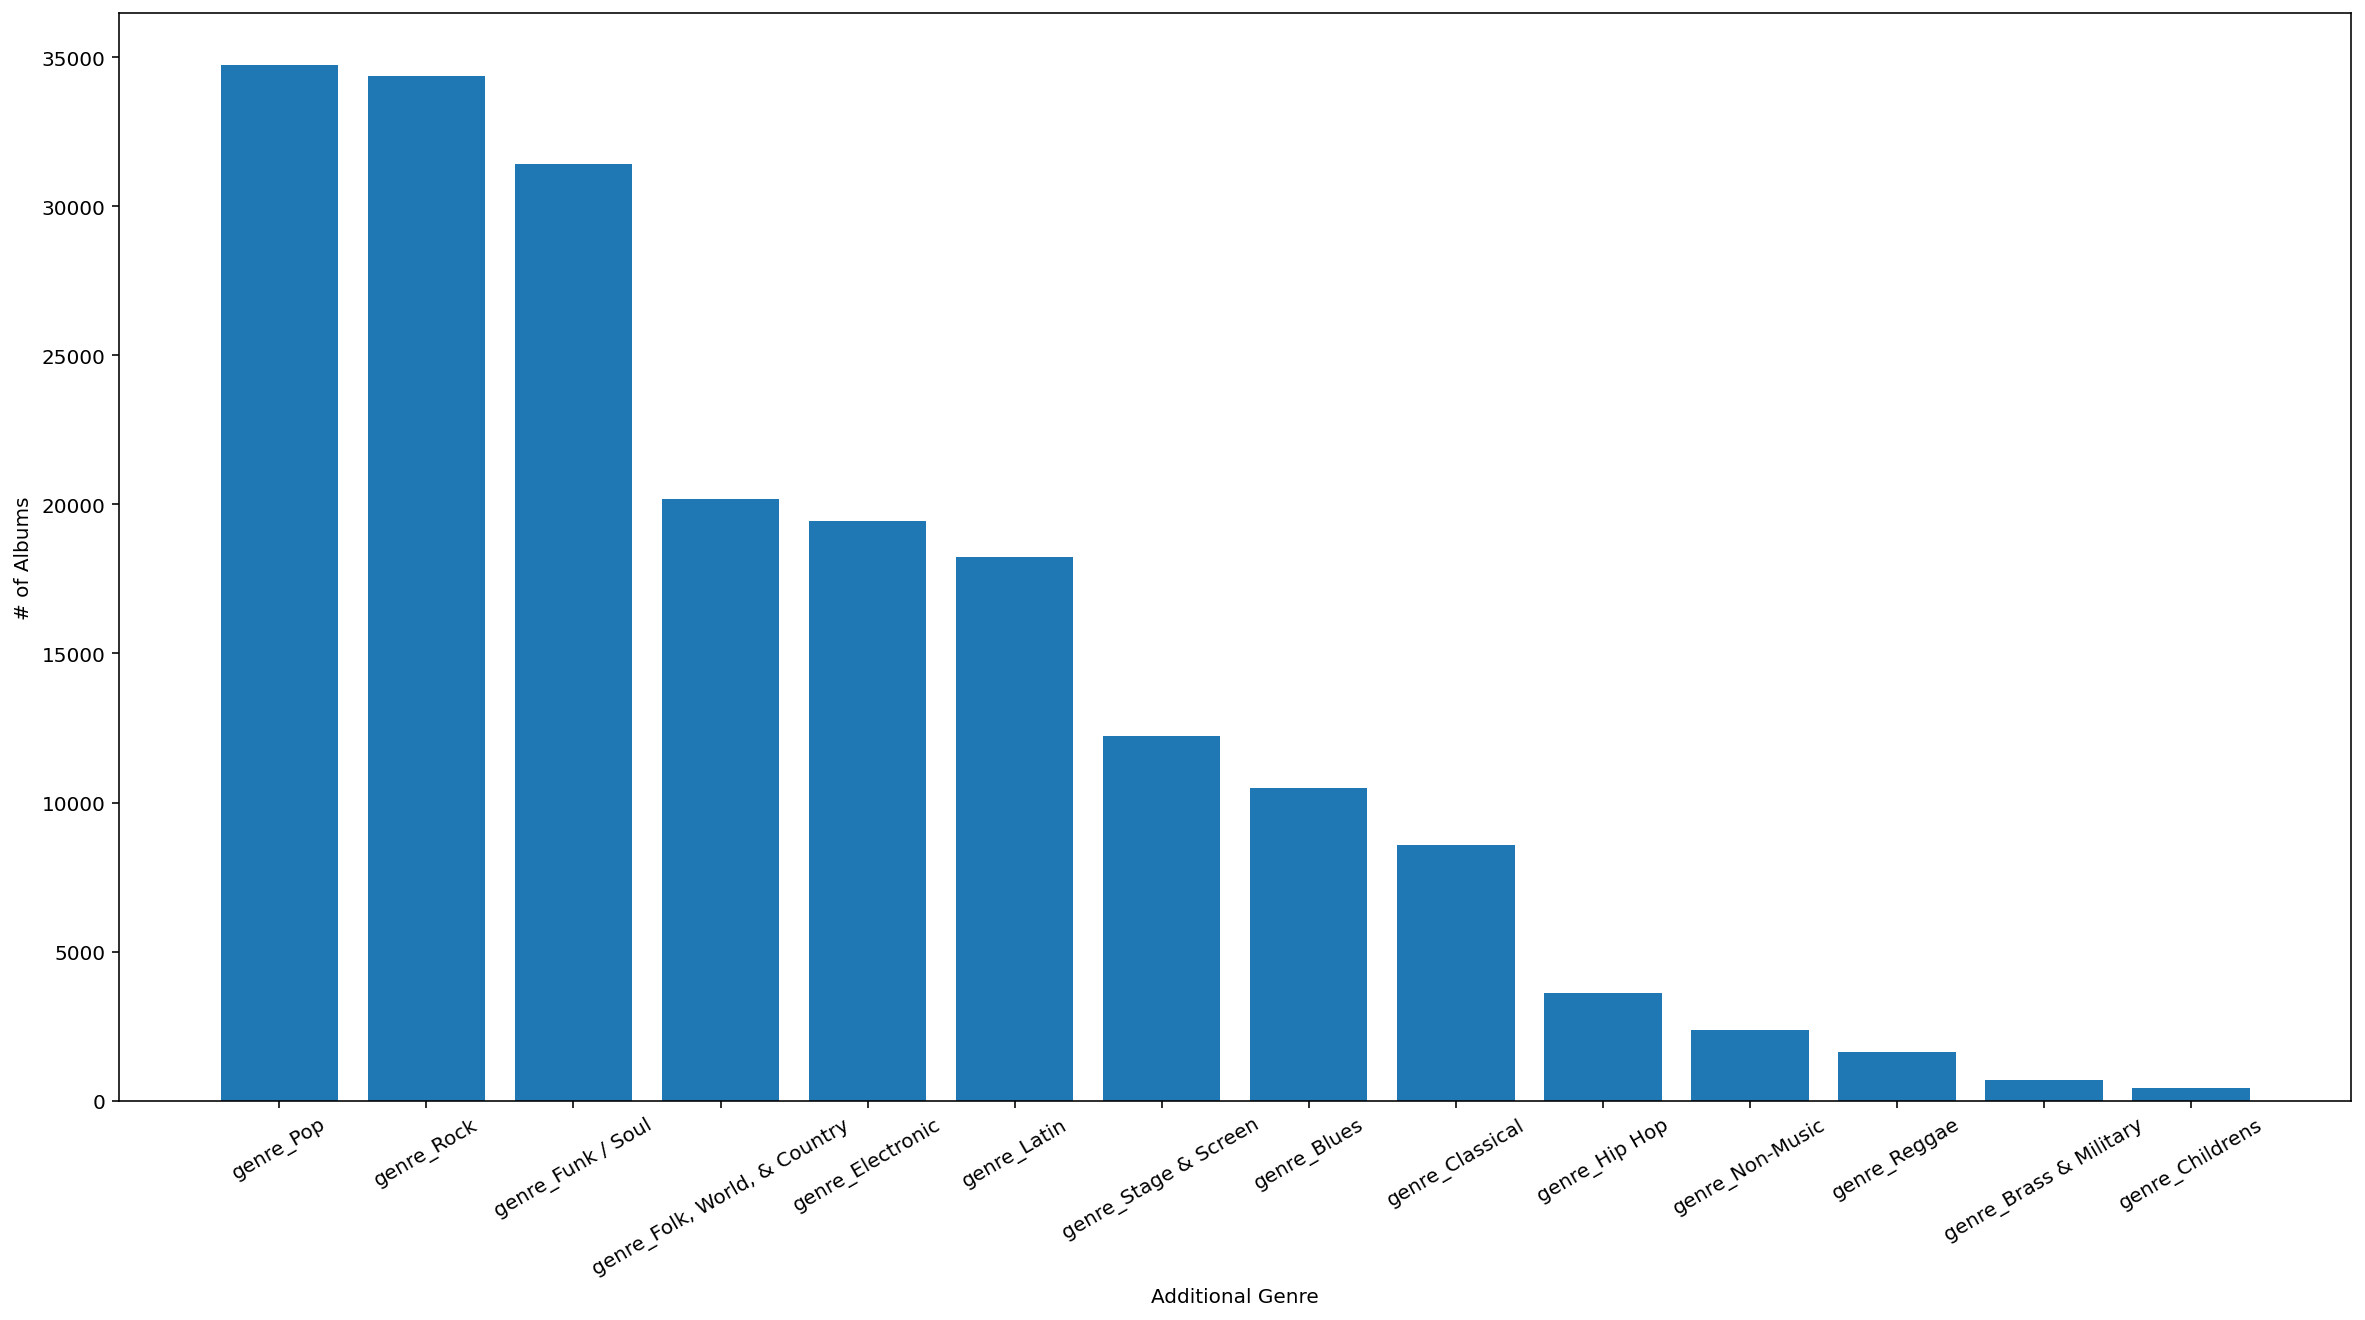

In [38]:
plt.figure(figsize=(20,10))
plt.xlabel('Additional Genre')
plt.ylabel('# of Albums')
plt.xticks(rotation=30)
plt.bar(genre_sum.index,genre_sum);
plt.show()

As we can see, there is relatively little cross-pollination with other genres, for albums listed as Jazz albums on Discogs. This is particularly evident, when we recognize that these groupings are not mutually exclusive, as any album can have any number of genres attributed to it. To identify what proportion of the dataset is composed of 'pure' Jazz albums, we refer to the filtering of the dataset below.

In [39]:
pure_jazz_albums = len(df[df[column_store._genre].sum(axis=1)==0])
print('There are {} albums which exclusively list Jazz as a genre, {}% of the dataset'.format(pure_jazz_albums,round(100*pure_jazz_albums/len(df),2)))

There are 165777 albums which exclusively list Jazz as a genre, 55.98% of the dataset


Given the dominance of 'pure' Jazz over any hybrid forms in the dataset, the question arises whether or not it may be more wise to focus on the prediction of the ``market_value`` for those albums that will likely offer a more homogenous subset of the rest of the data and therefore a stronger model, given that we don't have access to the albums that most often makeup the rest of the genres. We take a look specifically at the correlations between each genre occurrence and the ``market_value`` target feature below.

In [40]:
market_value_indicator_correlations.loc[column_store._genre,:].sort_values(by='correlation',ascending=False)

correlation      sign
genre_Pop                        0.054363  negative
genre_Rock                       0.032185  positive
genre_Funk / Soul                0.031034  positive
genre_Latin                      0.029867  positive
genre_Classical                  0.015259  negative
genre_Blues                      0.014666  negative
genre_Electronic                 0.012448  negative
genre_Brass & Military           0.005871  negative
genre_Hip Hop                    0.005217  negative
genre_Non-Music                  0.004117  positive
genre_Stage & Screen             0.003083  positive
genre_Childrens                  0.001640  negative
genre_Reggae                     0.000529  negative
genre_Folk, World, & Country     0.000299  negative

Additionally, let us observe how many ``style`` indicator columns we would be able to remove if we focused purely on Jazz albums.

In [41]:
df_pure = df[df[column_store._genre].sum(axis=1)==0]
len(column_store._style) - len(df_pure[[style for style in column_store._style if df_pure[style].sum()==0]].columns)

206

The substantial decrease in dimensionality we can achieve by shifting our focus to 'pure' Jazz albums is non-trivial. As such, we will remove those rows with genres other than Jazz, and focus on estimating ``market_value`` purely for Jazz albums.

In [42]:
df = df_pure

In [43]:
df.drop([i for i in set.union(column_store._genre,column_store._style) if df[i].sum() == 0],axis=1,inplace=True)

In [44]:
column_store.fit(df,col_set)

## Styles
Next we will identify the characteristics of our ``style`` column, which we have encoded similarly to the ``genre`` column. As we have seen above, there has been a major reduction in the number of encoded ``style`` columns after having pivoted to a focus on 'pure' Jazz albums.

In [45]:
style_sum = df[column_store._style].sum()
style_sum.describe()

count      206.000000
mean      1106.572816
std       4172.682715
min          1.000000
25%          2.000000
50%          5.500000
75%         35.750000
max      39935.000000
dtype: float64

From the above description, we see that there are 206 unique styles which can be attributed to Jazz albums, with an average incidence of around 1104 albums associated with each style across the dataset, and a maximum of 39805 albums.
Let us gain further intuition around the distribution by plotting the incidence of the top 10% of styles

In [46]:
style_sum_top_10 = style_sum[style_sum > style_sum.quantile(0.9)].sort_values(ascending=False)

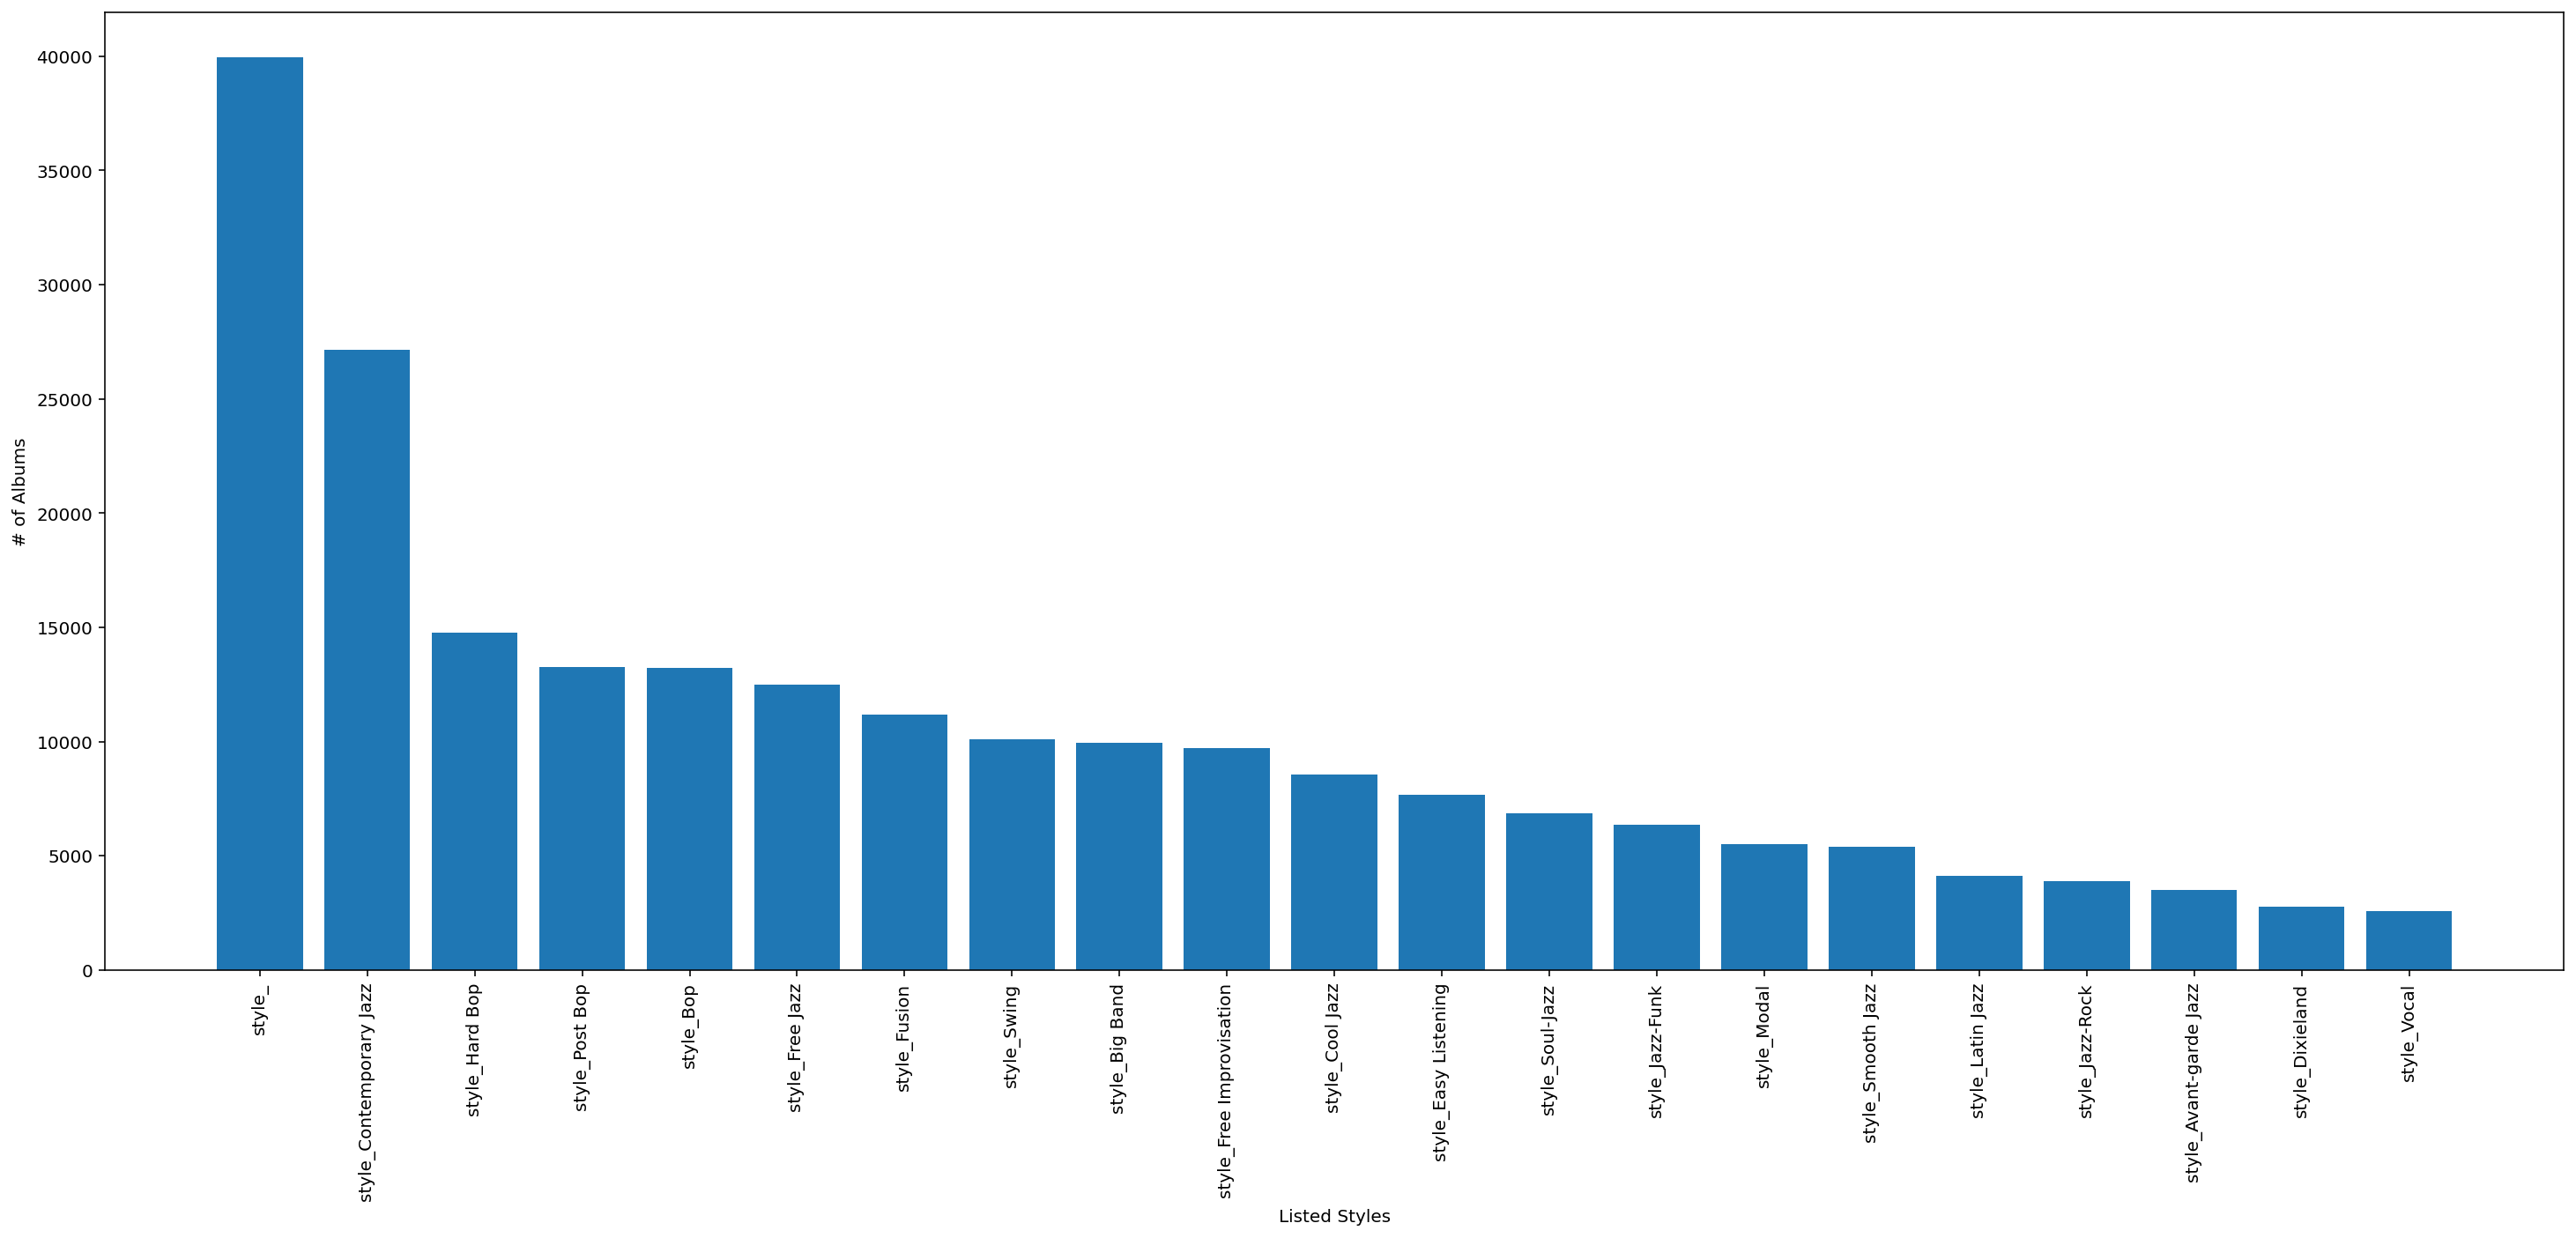

In [47]:
plt.figure(figsize=(25,10))
plt.xlabel('Listed Styles')
plt.ylabel('# of Albums')
plt.xticks(rotation=90)
plt.bar(style_sum_top_10.index,style_sum_top_10)
plt.show()

The first thing we notice, is that there is an empty style indicator column, ``style_``, which is likely the result of a trailing comma throughout the dataset in listing the styles for a given album. As such, we will remove this indicator from the dataset and revisualize the results

In [48]:
df.drop('style_',axis=1,inplace=True)

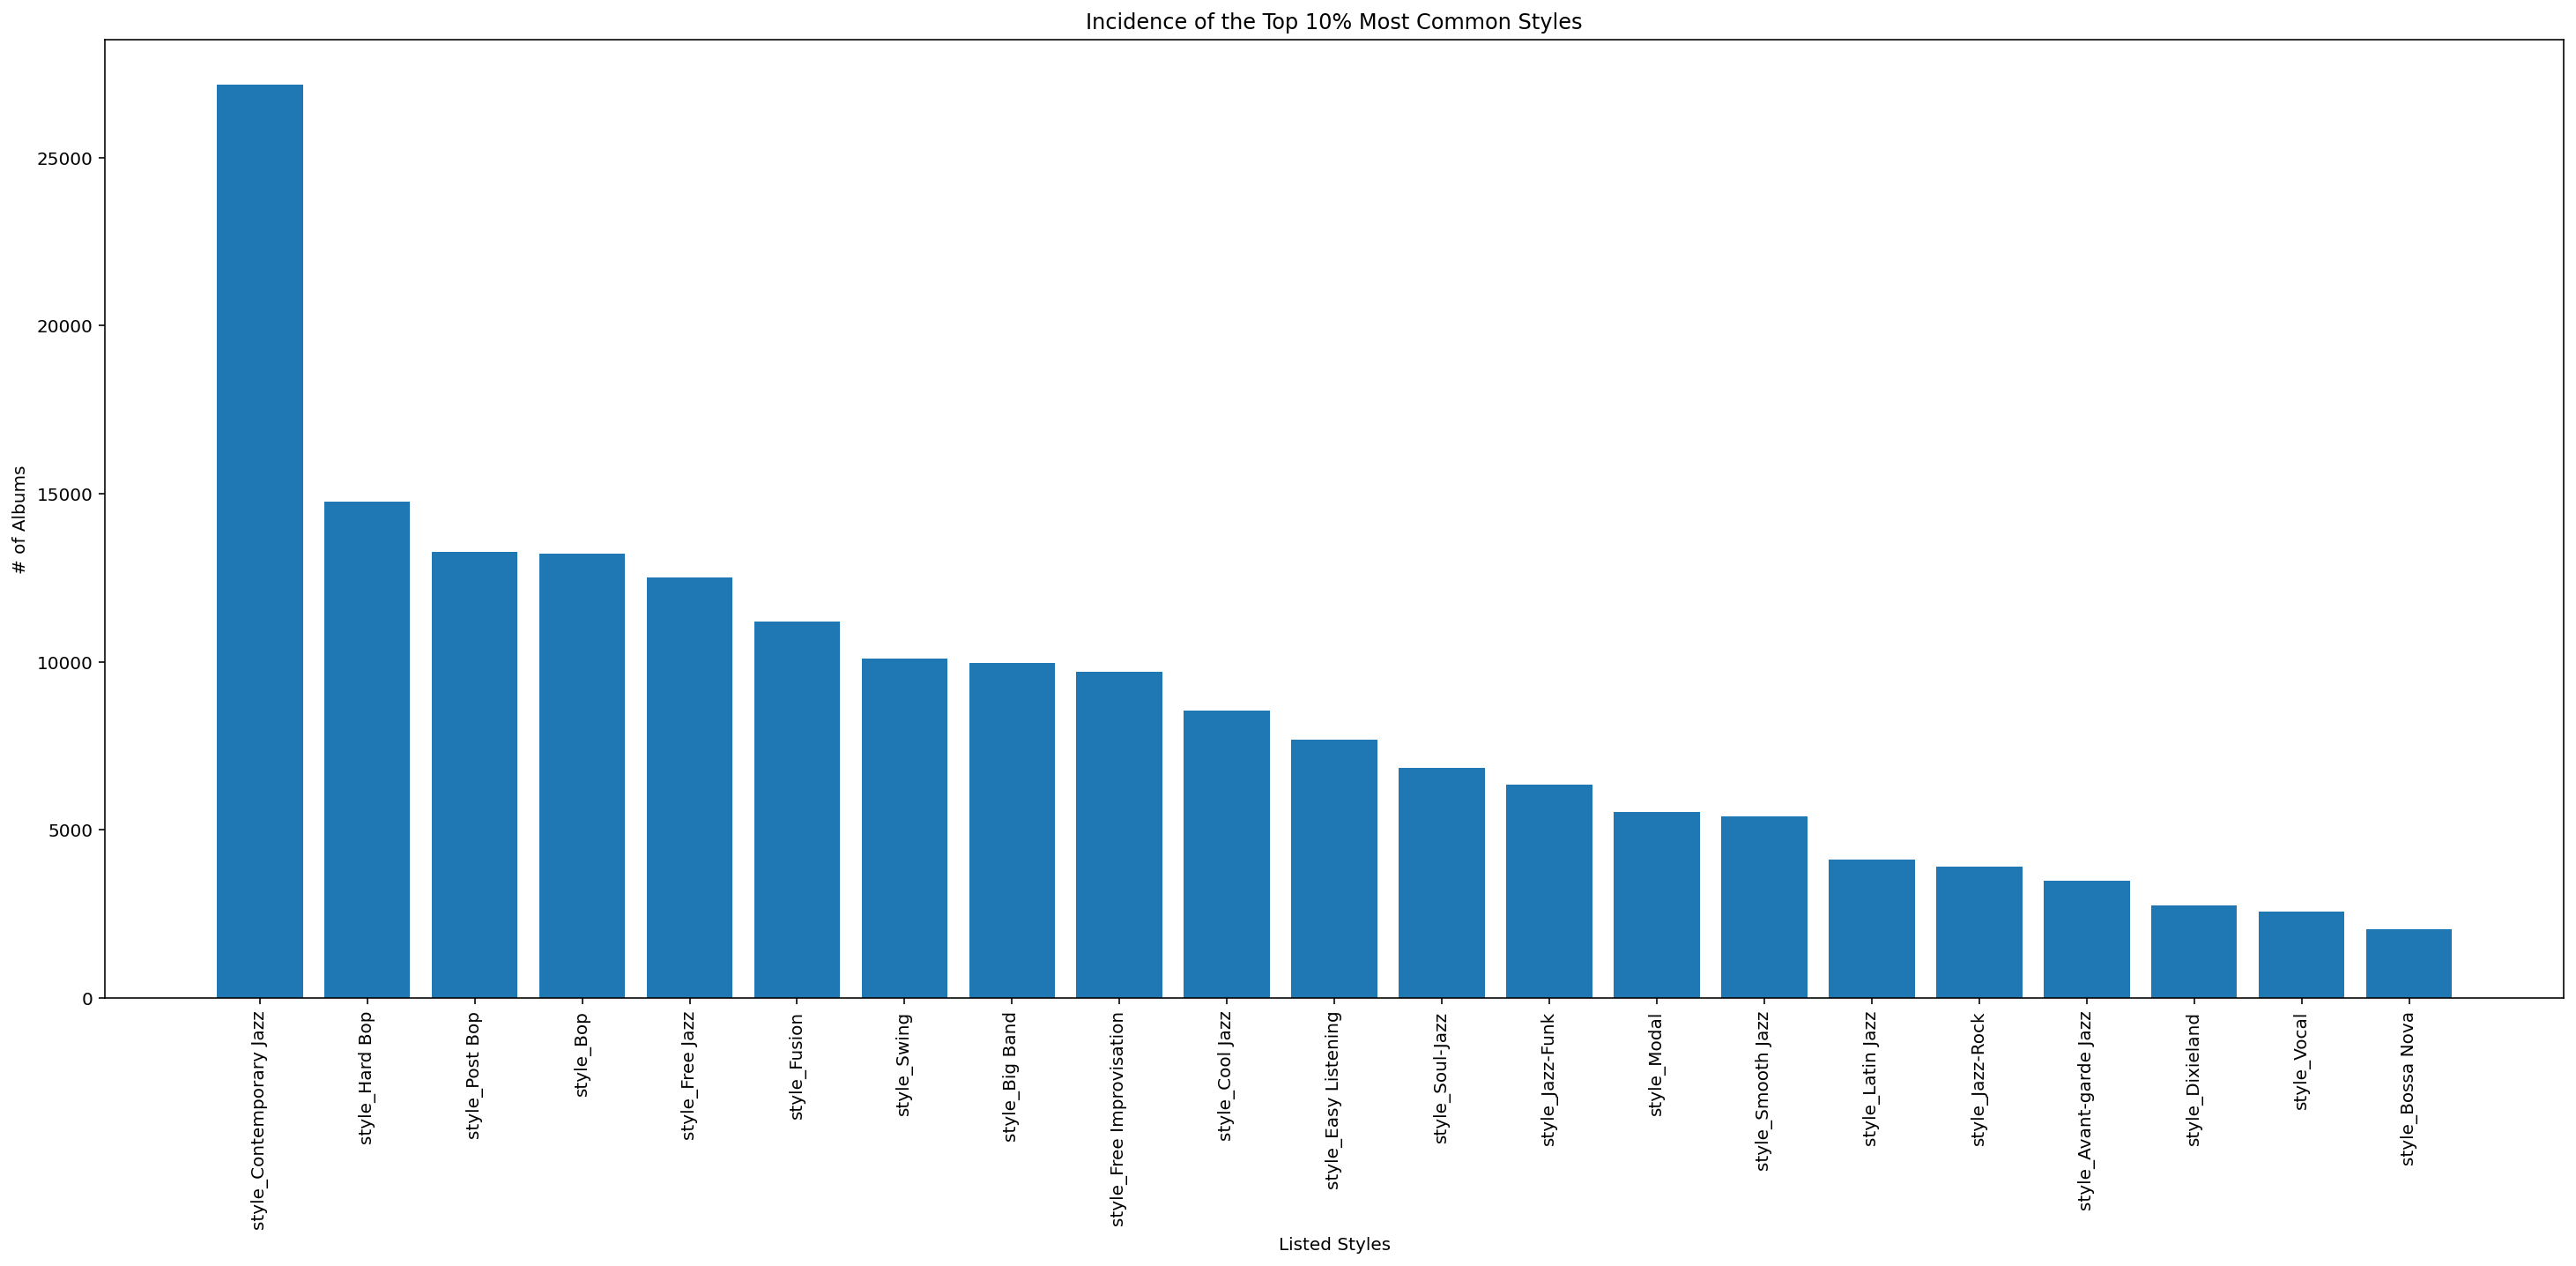

In [49]:
column_store.fit(df,col_set)
style_sum = df[column_store._style].sum()
style_sum_top_10 = style_sum[style_sum > style_sum.quantile(0.9)].sort_values(ascending=False)
plt.figure(figsize=(25,10))
plt.title('Incidence of the Top 10% Most Common Styles')
plt.xlabel('Listed Styles')
plt.ylabel('# of Albums')
plt.xticks(rotation=90)
plt.bar(style_sum_top_10.index,style_sum_top_10)
plt.show()

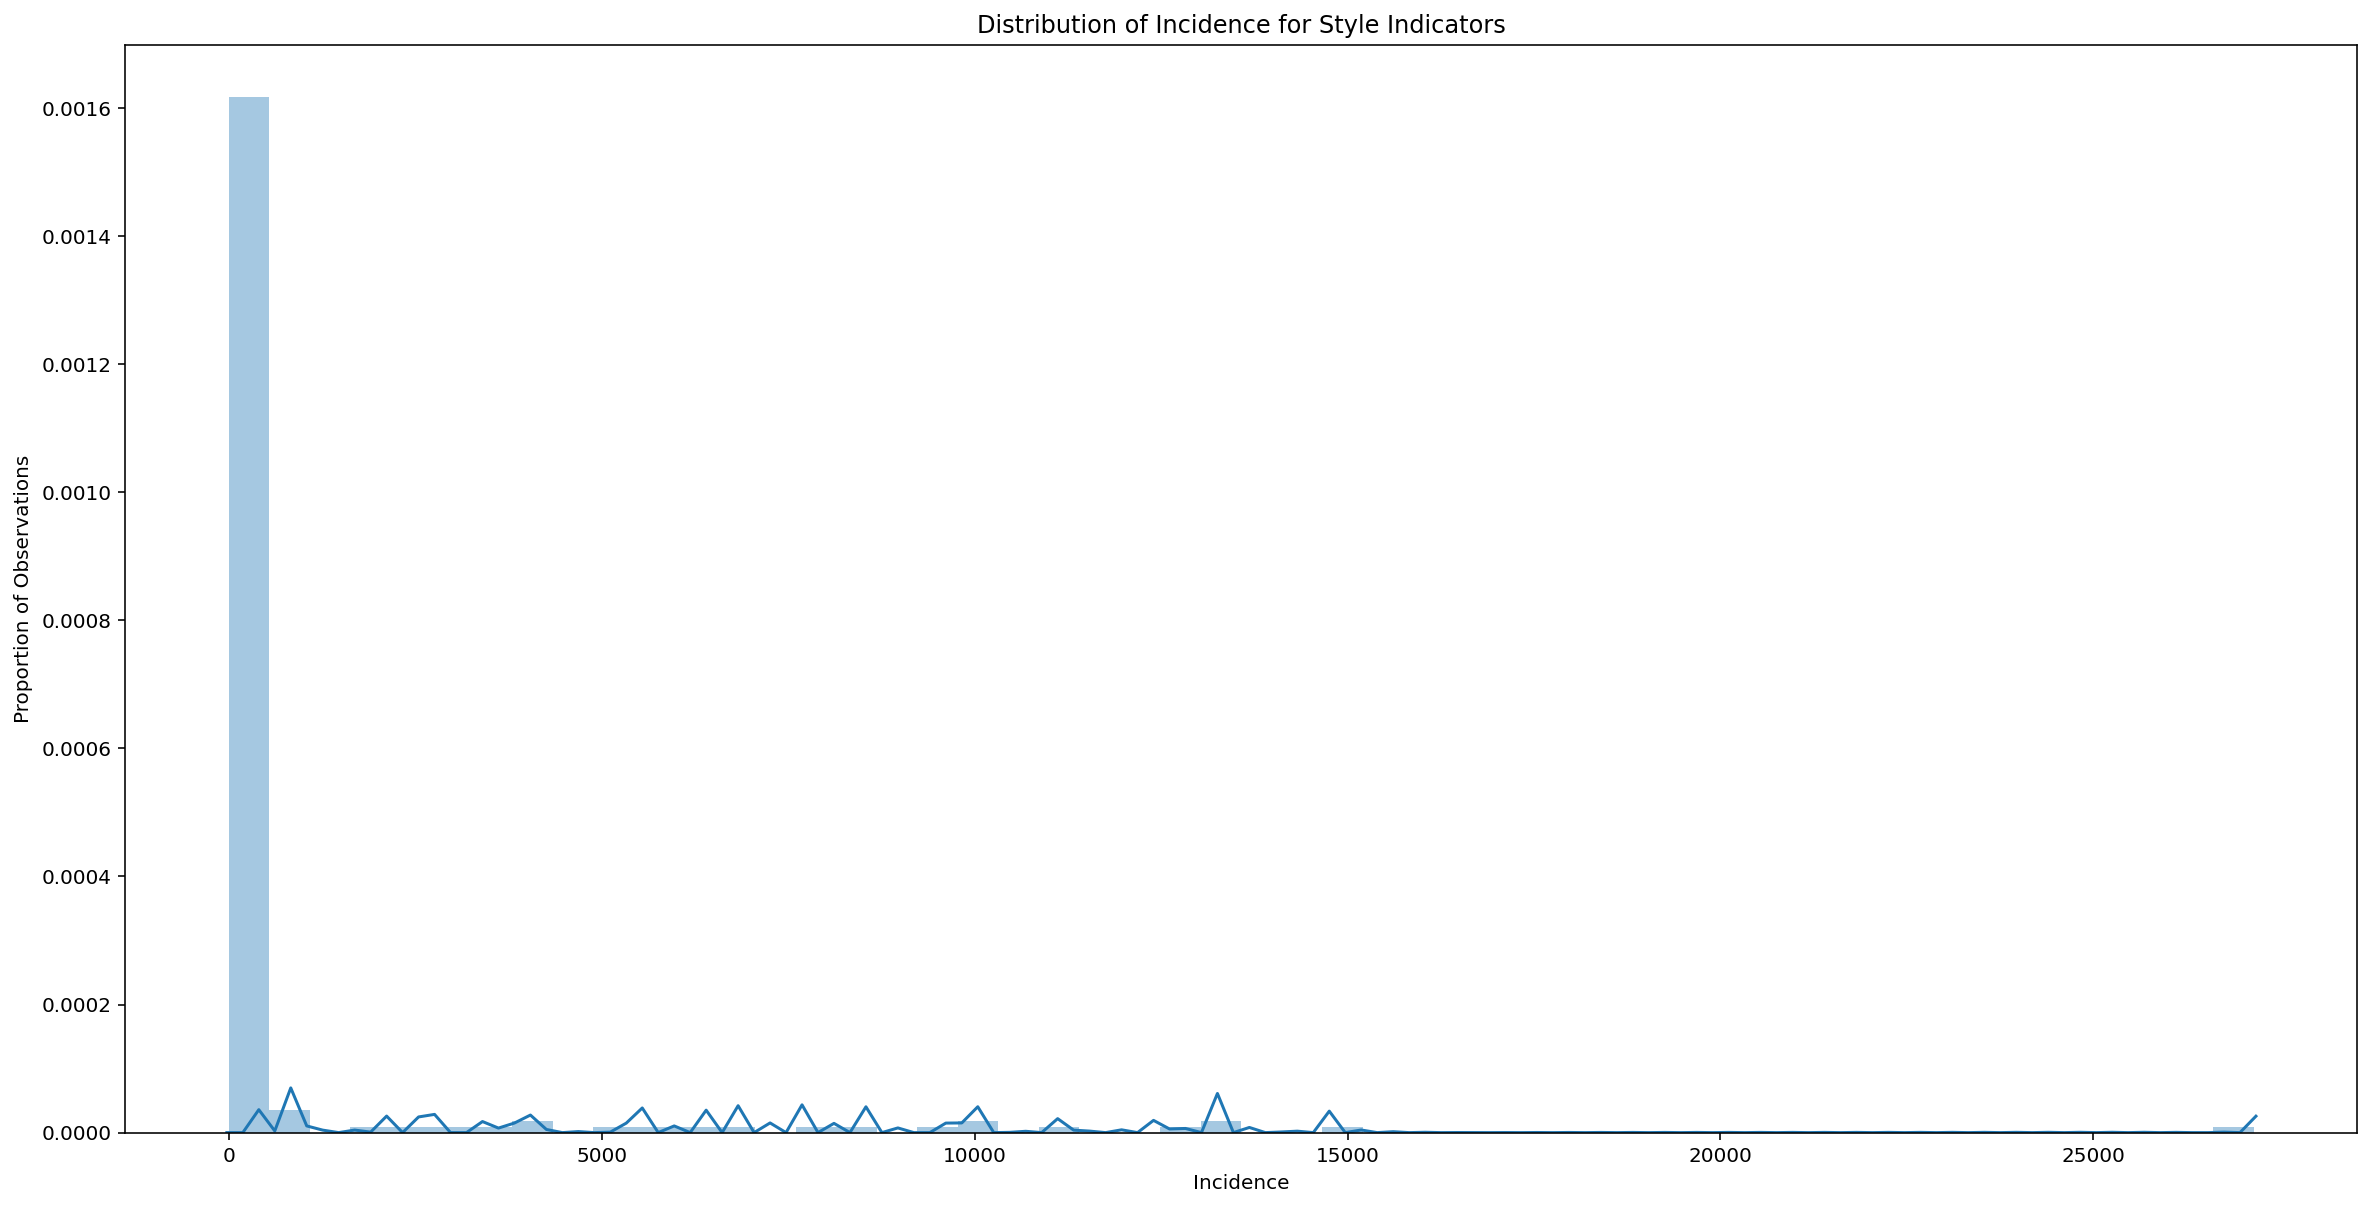

In [50]:
plt.figure(figsize=(20,10))
plt.title('Distribution of Incidence for Style Indicators')
plt.xlabel('Incidence')
plt.ylabel('Proportion of Observations')
sns.distplot(style_sum)
plt.show();

From the visualizations above, as well as our calling of the ``.describe()`` method on ``style_sum`` we can draw the conclusion that the incidence of individual styles of jazz is highly skewed towards zero. While it does seem from our investigation of the most highly correlated features with ``market_value``, that certain style indicators (``style_Modal`` & ``style_Big Band`` for example) are among the most useful in the estimation of an album's market value, the great majority of indicators in this grouping are not highly informative, while also hugely increasing the dimensionality of our core dataset.

As such, we take the approach of consolidating our indicator features for ``style``, such that the most relevant and frequently observed indicators can continue to be leveraged in the predictions of ``market_value``, while avoiding the issue of excessive upwards pressure on our data dimensionality. To do so, we use the ``IndicatorConsolidator()`` transformer, which counts the number of occurrences for the categories of a given indicator that has been encoded, and saves this information in a separated variable, while removing all those indicator features that do not meet a certain threshold criteria. In the implementation used below, we define an incidence minimum for encoded indicator columns we wish to retain for a given encoded feature, and replace the rest with a ``indicator_Other`` dummy feature, which is equal to 1 if any other style is attributed to the album. The transformer also introduces a ``counter_style`` feature that tracks the stylistic heterogeneity of a given record.

In [51]:
style_consolidator = IndicatorConsolidator(columns=column_store._style,
                                           output_column='style_Other',
                                           threshold=int(0.1*len(df)),
                                           counter_name='counter_style')                                         
                                           

In [52]:
style_consolidator.fit_transform(df)

release_id  market_price  units_for_sale   have  want  average_rating  \
1          6910984          7.21             3.0    4.0   2.0             NaN   
2          8592628          7.75             5.0   17.0   0.0            5.00   
3          8684706        125.00             1.0    1.0   7.0             NaN   
4          8049748          5.00             2.0    9.0   8.0             NaN   
5         13028335           NaN             NaN    1.0   5.0             NaN   
...            ...           ...             ...    ...   ...             ...   
296148     8388585         64.48             1.0    2.0   8.0             NaN   
296149     9961452         30.88             4.0    8.0   8.0            5.00   
296150     5767152          9.64             2.0    3.0   5.0             NaN   
296152     7340022         11.85            10.0  182.0  89.0            4.42   
296154    11534331          1.32             3.0   13.0   1.0             NaN   

        rating_count  last_sold  number_of_tracks  running_time  ...  \
1                0.0 2019-03-04               8.0           NaN  ...   
2                2.0        NaT               8.0           NaN  ...   
3                0.0        NaT               8.0           NaN  ...   
4                0.0 2016-12-04              12.0           NaN  ...   
5                0.0 2019-04-06               8.0           NaN  ...   
...              ...        ...               ...           ...  ...   
296148           0.0        NaT               8.0           NaN  ...   
296149           1.0        NaT               6.0     41.516667  ...   
296150           0.0        NaT              10.0           NaN  ...   
296152          19.0 2019-12-29               5.0           NaN  ...   
296154           0.0        NaT              10.0     75.383333  ...   

        format_description_⅛"  era_swing  era_modern era_contemporary  \
1                           0          1           0                0   
2                           0          1           0                0   
3                           0          1           0                0   
4                           0          1           0                0   
5                           0          1           0                0   
...                       ...        ...         ...              ...   
296148                      0          0           0                1   
296149                      0          0           0                1   
296150                      0          0           1                0   
296152                      0          0           0                1   
296154                      0          0           0                1   

        period_big_band  period_bebop  period_cool period_fusion  \
1                     1             0            0             0   
2                     1             0            0             0   
3                     1             0            0             0   
4                     1             0            0             0   
5                     1             0            0             0   
...                 ...           ...          ...           ...   
296148                0             0            0             1   
296149                0             0            0             1   
296150                0             1            1             0   
296152                0             0            0             1   
296154                0             0            0             1   

       counter_style style_Other  
1                  1           1  
2                  2           1  
3                  1           1  
4                  2           1  
5                  1           1  
...              ...         ...  
296148             0           0  
296149             1           1  
296150             2           1  
296152             2           1  
296154             1           0  

[165777 rows x 373 columns]

In [53]:
print('Consolidation of style results in a reduction of dimensionality by: ', len(df.columns)-len(style_consolidator.fit_transform(df).columns))

Consolidation of style results in a reduction of dimensionality by:  202


## Format Description
As we will see, the encoding of the ``format_description`` column suffers from a similar issue as the ``style`` column.

In [54]:
format_description_sum = df[column_store._format_description].sum().sort_values(ascending=False)
format_description_sum.describe()

count       115.000000
mean       3183.391304
std       17397.607104
min           0.000000
25%           0.000000
50%           8.000000
75%         176.000000
max      165410.000000
dtype: float64

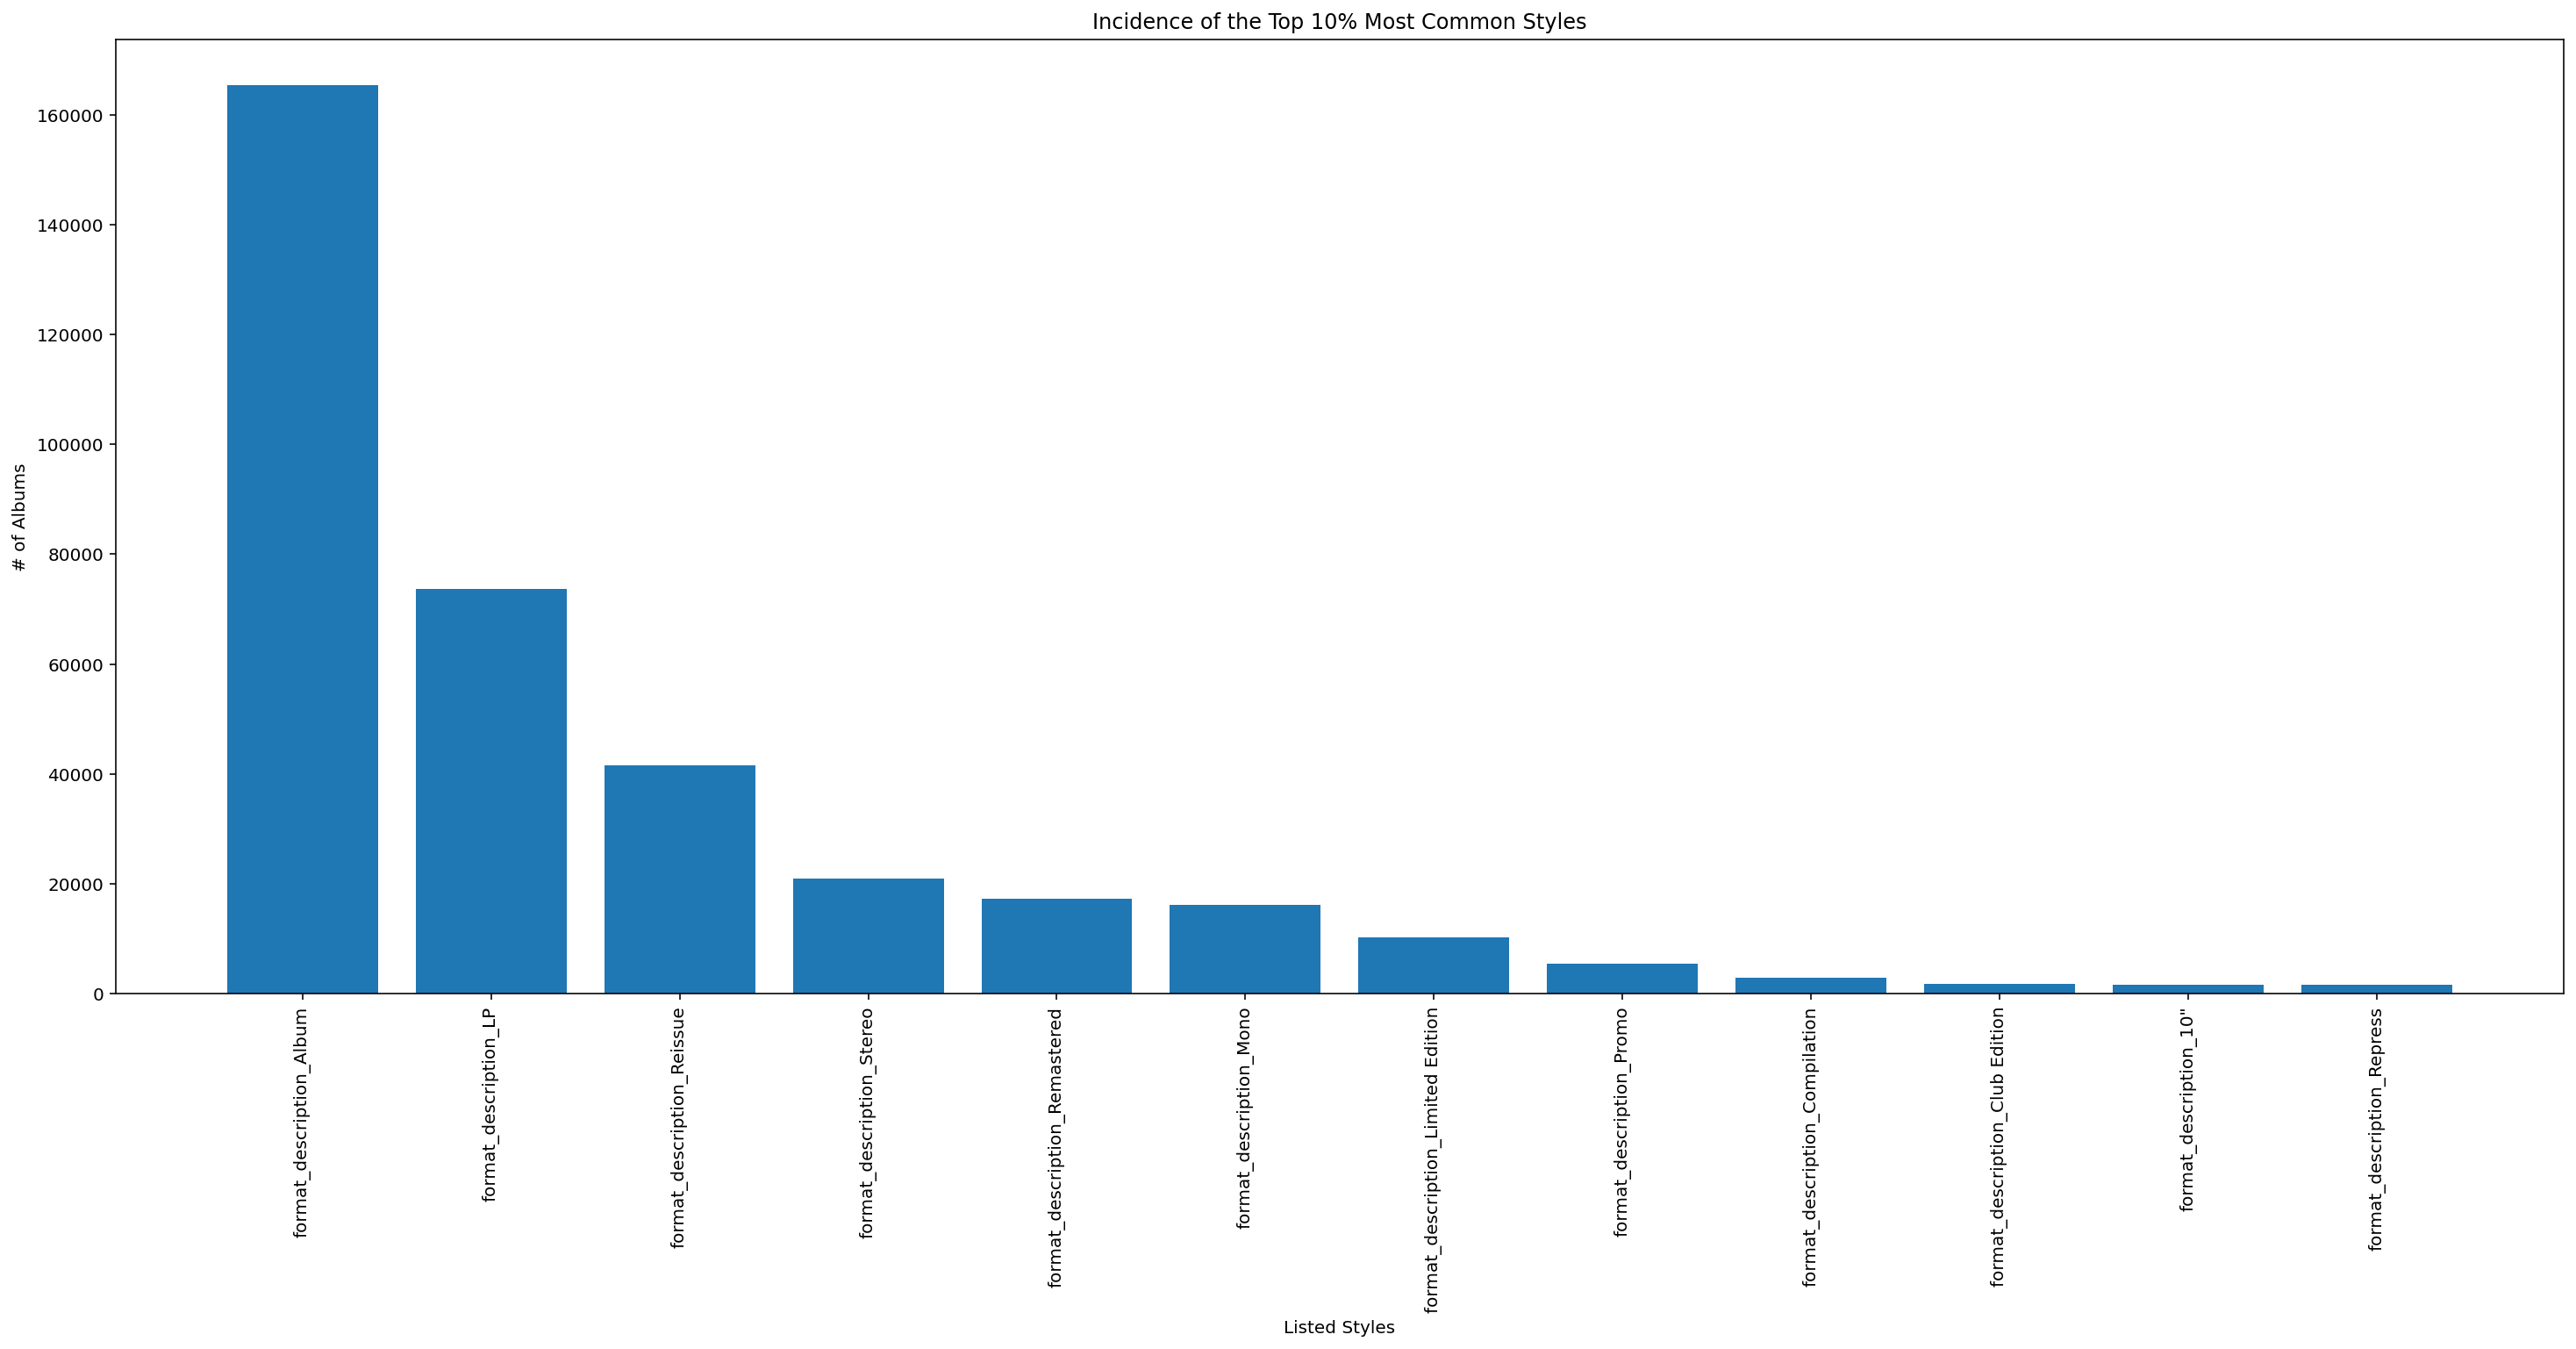

In [55]:
format_description_sum_top_10 = format_description_sum[format_description_sum > format_description_sum.quantile(0.9)].sort_values(ascending=False)
plt.figure(figsize=(25,10))
plt.title('Incidence of the Top 10% Most Common Styles')
plt.xlabel('Listed Styles')
plt.ylabel('# of Albums')
plt.xticks(rotation=90)
plt.bar(format_description_sum_top_10.index,format_description_sum_top_10)
plt.show()

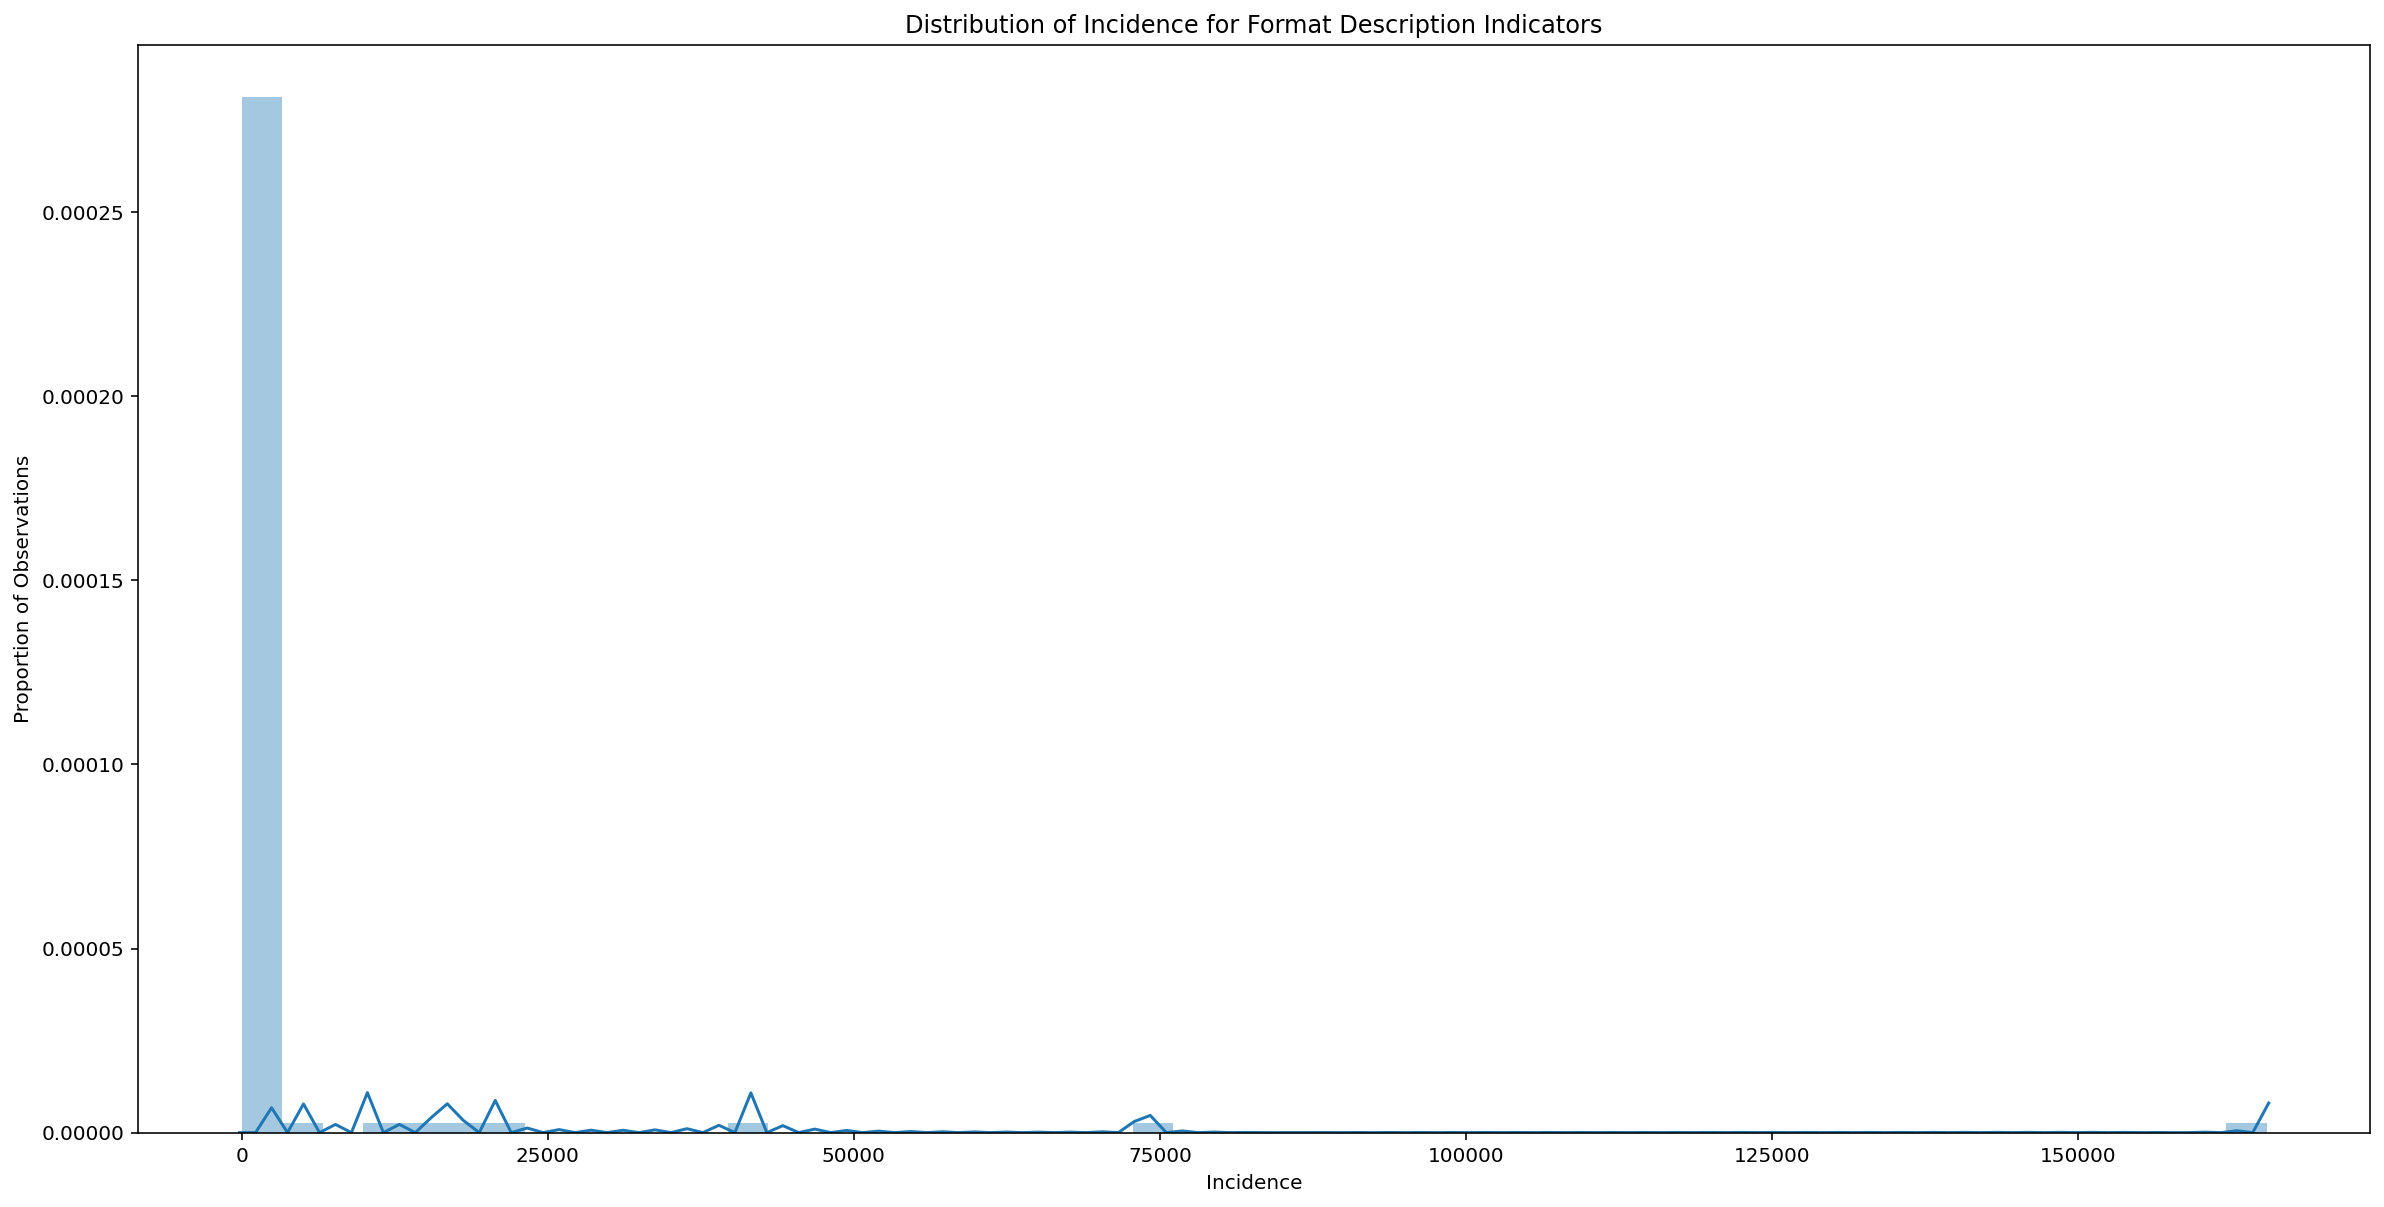

In [56]:
plt.figure(figsize=(20,10))
plt.title('Distribution of Incidence for Format Description Indicators')
plt.xlabel('Incidence')
plt.ylabel('Proportion of Observations')
sns.distplot(format_description_sum)
plt.show();

As previously mentioned, the ``format_description`` feature suffers from a leftward skew in terms of distribution in a similar manner as the ``style`` feature, with an even stronger skew, as the ``album`` and ``LP`` descriptions have a very high proportion of incidence across the dataset. As such, we will apply the same consolidation procedure of the feature as in the ``style`` case.

In [57]:
description_consolidator = IndicatorConsolidator(columns=column_store._format_description,
                                                 output_column='format_description_Other',
                                                 threshold=int(0.1*len(df)),
                                                 counter_name='counter_format_description')

In [58]:
description_consolidator.fit_transform(df)

release_id  market_price  units_for_sale   have  want  average_rating  \
1          6910984          7.21             3.0    4.0   2.0             NaN   
2          8592628          7.75             5.0   17.0   0.0            5.00   
3          8684706        125.00             1.0    1.0   7.0             NaN   
4          8049748          5.00             2.0    9.0   8.0             NaN   
5         13028335           NaN             NaN    1.0   5.0             NaN   
...            ...           ...             ...    ...   ...             ...   
296148     8388585         64.48             1.0    2.0   8.0             NaN   
296149     9961452         30.88             4.0    8.0   8.0            5.00   
296150     5767152          9.64             2.0    3.0   5.0             NaN   
296152     7340022         11.85            10.0  182.0  89.0            4.42   
296154    11534331          1.32             3.0   13.0   1.0             NaN   

        rating_count  last_sold  number_of_tracks  running_time  ...  \
1                0.0 2019-03-04               8.0           NaN  ...   
2                2.0        NaT               8.0           NaN  ...   
3                0.0        NaT               8.0           NaN  ...   
4                0.0 2016-12-04              12.0           NaN  ...   
5                0.0 2019-04-06               8.0           NaN  ...   
...              ...        ...               ...           ...  ...   
296148           0.0        NaT               8.0           NaN  ...   
296149           1.0        NaT               6.0     41.516667  ...   
296150           0.0        NaT              10.0           NaN  ...   
296152          19.0 2019-12-29               5.0           NaN  ...   
296154           0.0        NaT              10.0     75.383333  ...   

        format_description_Stereo  era_swing  era_modern era_contemporary  \
1                               0          1           0                0   
2                               0          1           0                0   
3                               0          1           0                0   
4                               0          1           0                0   
5                               0          1           0                0   
...                           ...        ...         ...              ...   
296148                          0          0           0                1   
296149                          0          0           0                1   
296150                          0          0           1                0   
296152                          0          0           0                1   
296154                          0          0           0                1   

        period_big_band  period_bebop  period_cool period_fusion  \
1                     1             0            0             0   
2                     1             0            0             0   
3                     1             0            0             0   
4                     1             0            0             0   
5                     1             0            0             0   
...                 ...           ...          ...           ...   
296148                0             0            0             1   
296149                0             0            0             1   
296150                0             1            1             0   
296152                0             0            0             1   
296154                0             0            0             1   

       counter_format_description format_description_Other  
1                               4                        1  
2                               5                        1  
3                               3                        1  
4                               3                        1  
5                               3                        1  
...                           ...                      ...  
2

In [59]:
print('Consolidation of style results in a reduction of dimensionality by: ', len(df.columns)-len(description_consolidator.fit_transform(df).columns))

Consolidation of style results in a reduction of dimensionality by:  108


## Format Name
We apply a similar processing step to the ``format_name`` feature, which differs slightly from ``style`` and ``format_description``, in that it does not have multiple values ascribed to a given entry. As such, this feature was simply one-hot encoded. Let us see if the complete encoding of this feature makes sense, or whether we can consolidate it further and reduce the dimensionality of our data.

In [65]:
format_name_sum = df[column_store._format_name].sum().sort_values(ascending=False)
format_name_sum.describe()

count       34.000000
mean      4875.794118
std      18929.563690
min          0.000000
25%          0.000000
50%          6.500000
75%         93.750000
max      83958.000000
dtype: float64

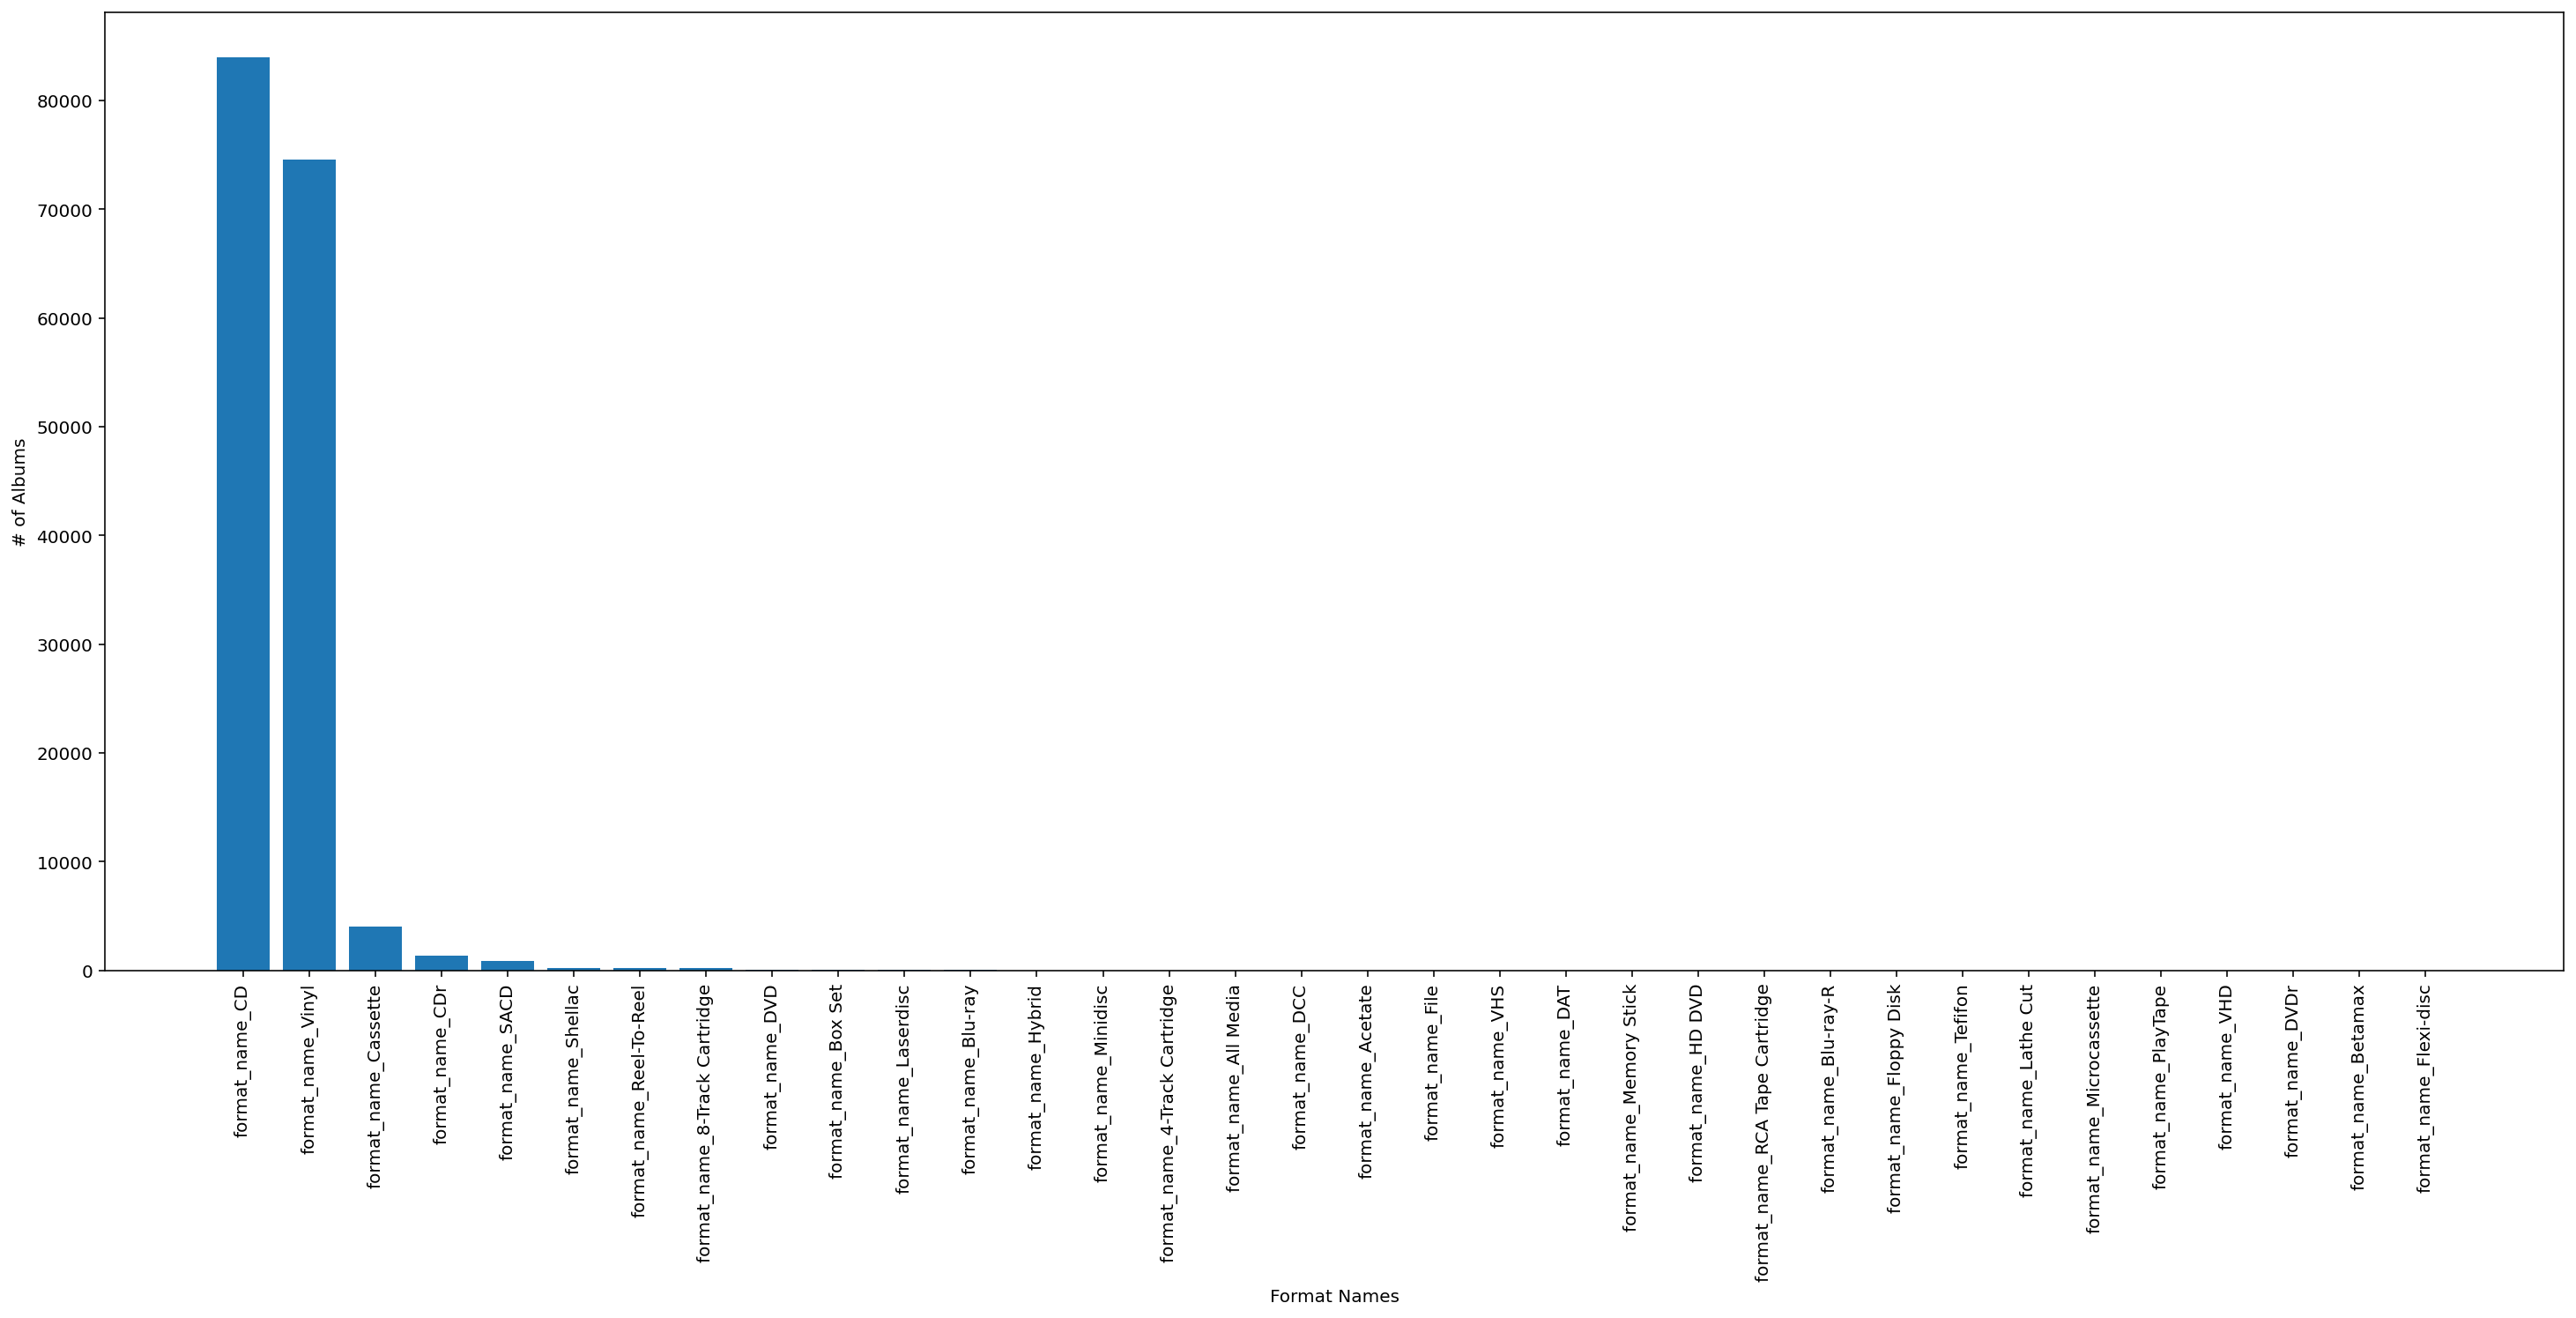

In [66]:
plt.figure(figsize=(25,10))
plt.xlabel('Format Names')
plt.ylabel('# of Albums')
plt.xticks(rotation=90)
plt.bar(format_name_sum.index,format_name_sum)
plt.show()

From the above, we can see that it would be wise to reduce the ``format_name`` indicator variable dimensionality, as there are only three non-trivially large format categories, namely ``CD``, ``Vinyl`` and ``Cassette``. The rest we will combine into an ``Other`` indicator.

In [67]:
format_name_consolidator = IndicatorConsolidator(output_column='format_name_other',threshold=5000)
format_name_consolidator.fit_transform(pd.get_dummies(df['format_name']))

CD  Vinyl  format_name_other
1        0      0                  1
2        0      0                  1
3        0      0                  1
4        0      0                  1
5        0      0                  1
...     ..    ...                ...
296148   1      0                  0
296149   1      0                  0
296150   0      1                  0
296152   0      1                  0
296154   1      0                  0

[165777 rows x 3 columns]

## Mapping Most Albums
In order to obtain a more spatial understanding of the distribution of Jazz albums, we visualize the releases with respect to each country in our dataset.

In [68]:
map_df = gpd.read_file(os.path.join(os.getcwd(),'data/data/countries/ne_110m_admin_0_countries.shp'))

In [69]:
#Specifying the countries to be visualized by filtering out countries with no direct modern equivalent in UN encoding
visualization_countries = list(filter(lambda x: x not in ['country_yugoslavia','country_ussr','country_taiwan'],column_store._geography_country))
country_album_count = df[visualization_countries].sum()

In [70]:
def assign_country_codes(country):
    try:
        return COUNTRY_CODES[country.split('_')[-1]]
    except KeyError as e:
        return '000'

In [71]:
country_codes = pd.Series(tuple(map(assign_country_codes,visualization_countries)),index=visualization_countries)
country_df = pd.DataFrame(country_album_count)
country_df['codes'] = country_codes
country_df['ISO_A3'] = country_df.loc[:,'codes'].map(M49_TO_ISO3) 
country_df.sort_values(0,ascending=False).head(25)

0 codes ISO_A3
country_united states of america                    55174   840    USA
country_japan                                       26536   392    JPN
country_germany                                     13503   276    DEU
country_united kingdom of great britain and nor...  11877   826    GBR
country_france                                       8149   250    FRA
country_canada                                       6230   124    CAN
country_italy                                        6210   380    ITA
country_netherlands                                  3597   528    NLD
country_spain                                        3524   724    ESP
country_switzerland                                  2218   756    CHE
country_denmark                                      2213   208    NaN
country_sweden                                       1790   752    SWE
country_australia                                    1665   036    AUS
country_poland                                       1650   616    POL
country_norway                                       1503   578    NOR
country_portugal                                     1231   620    PRT
country_brazil                                       1086   076    BRA
country_austria                                       868   040    AUT
country_unknown                                       824   000    NaN
country_finland                                       759   246    FIN
country_belgium                                       723   056    BEL
country_czechia                                       630   203    NaN
country_slovakia                                      594   703    SVK
country_russian federation                            491   643    RUS
country_greece                                        460   300    GRC

As we can see from the above, the great majority of albums come from the USA, Japan and Germany, with a very long tail in album releases from areas from the rest of the world. To get a better understanding of the scale, we will plot this data geospatially.

In [72]:
map_country_df = map_df.set_index('ISO_A3').join(country_df.set_index('ISO_A3'))
#Filling countries without values with 0 albums
map_country_df.fillna(0,inplace=True)

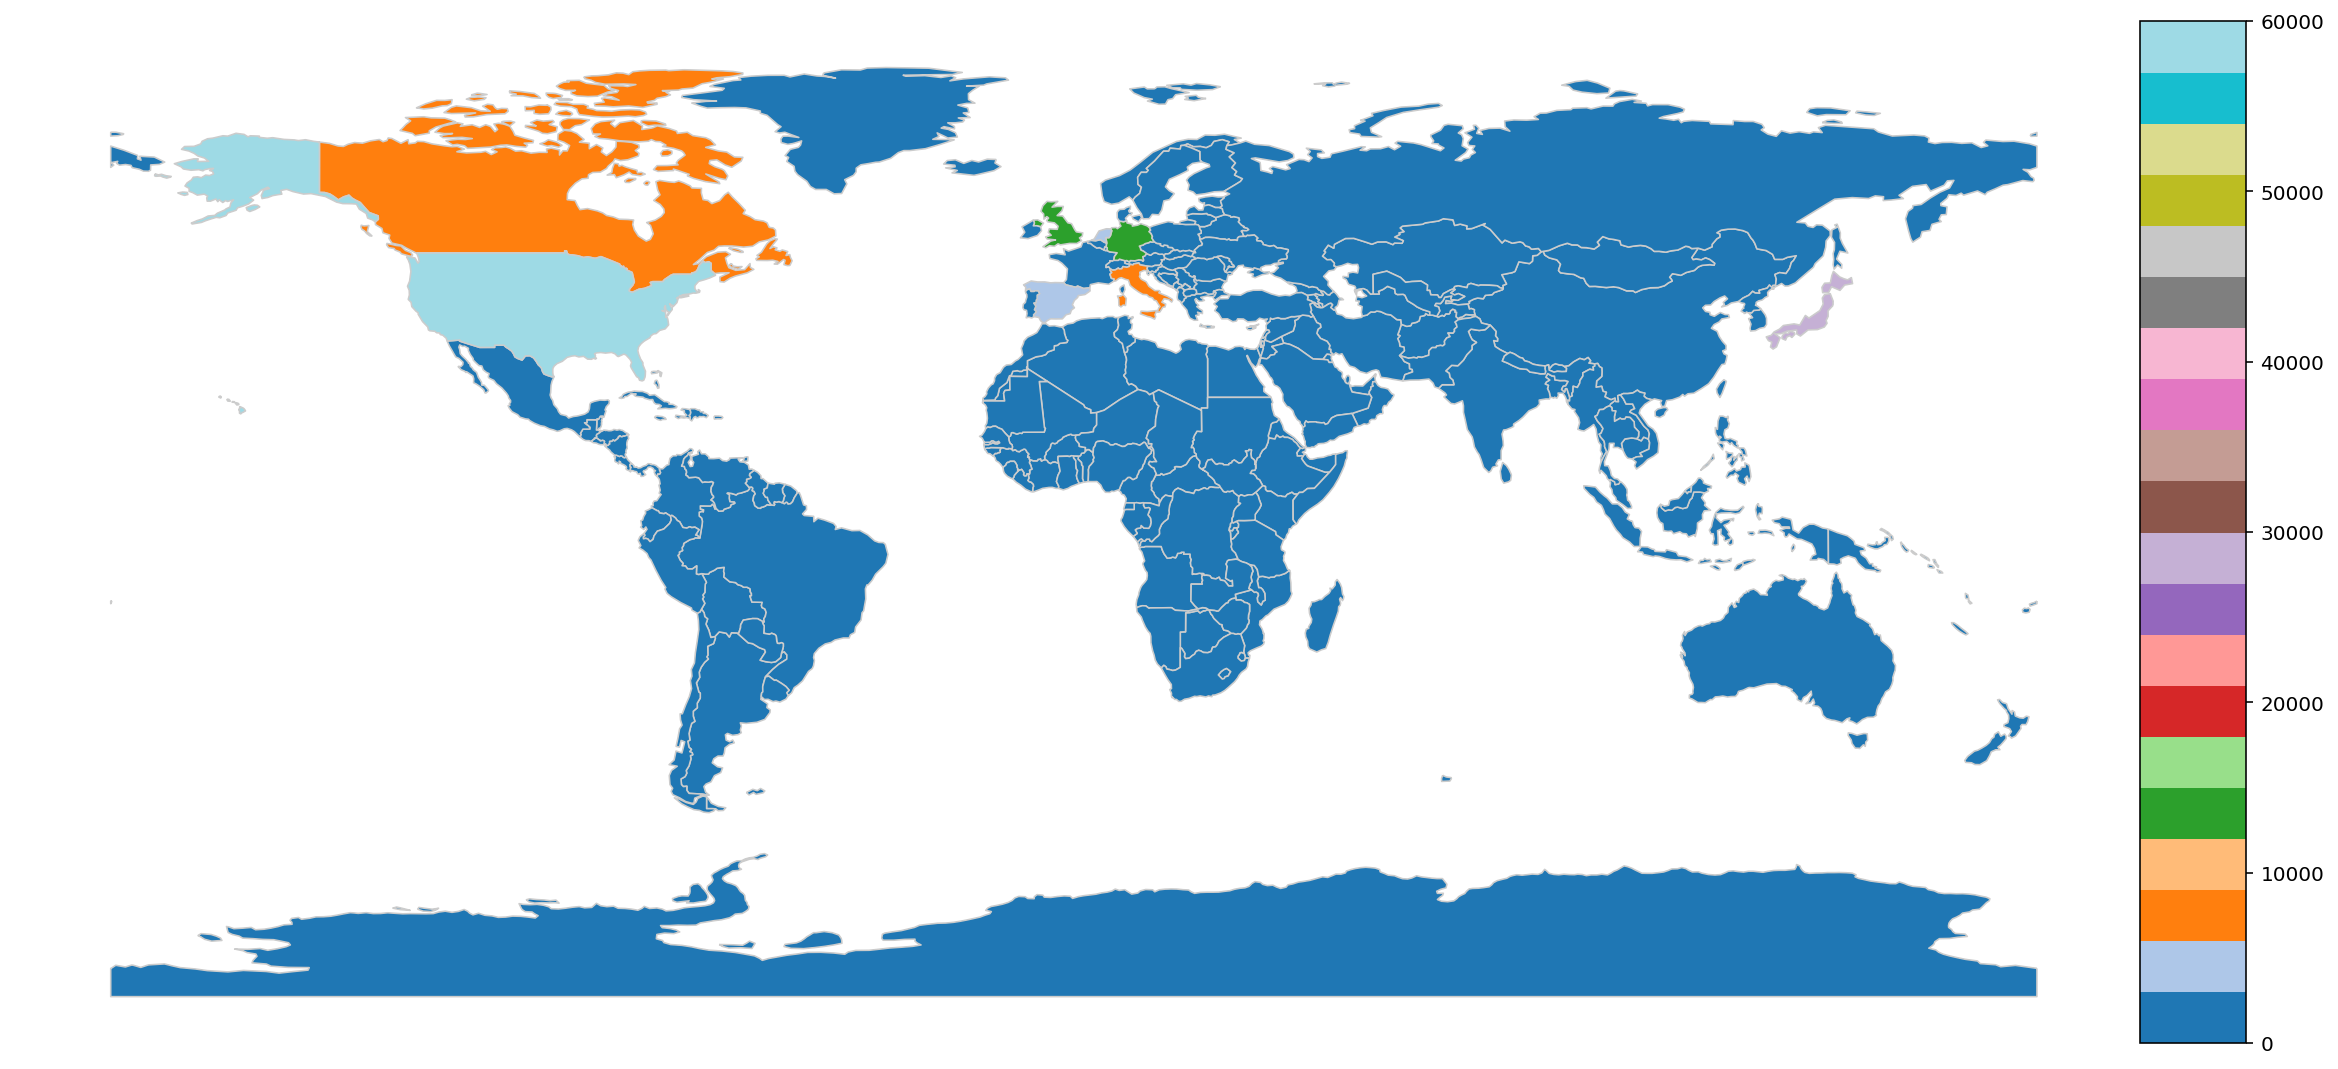

In [73]:
#Plotting the Map Visualization
def plot_map(df,column):
    vmin, vmax = min(df[column]),round(max(df[column]),-4)
    fig, ax = plt.subplots(1,figsize=(20,20))
    df.plot(column=column,cmap='tab20',linewidth=0.8,ax=ax,edgecolor='0.8')
    ax.axis('off')
    sm = plt.cm.ScalarMappable(cmap='tab20',norm=plt.Normalize(vmin=vmin,vmax=vmax))
    sm._a = []
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(sm,cax=cax)
    plt.show()
plot_map(map_country_df,0)

As alluded to previously,the majority of Jazz album releases come from North America (particularly the USA), Japan and Europe (particularly Germany and the UK). 

# High Level Features
In order to proxy for the visual aspect related to purchasing albums, we use a pre-trained MobileNetV2 model in order to extract high level features from the cover images scraped from Discogs.com. With this we hope to identify whether or not there is any useful information in the visual representation of a given album in the prediction of its market value, and if visual clusters can be drawn related to this target feature.
## Loading and Cleaning
As a first step, we will load the high level features we have generated using the pre-trained MobileNetV2 model and merge this data with our core dataset

In [74]:
with np.load(os.path.join(DATA_PATH,'high_level_features_labelled.npz')) as data:
    high_level_feature_df = pd.concat([pd.DataFrame(data[section]) for section in ('release_id','bitmap','features')],axis=1)
    high_level_feature_df.columns = ['release_id', 'bitmap'] + ['feature_%s' % i for i in range(1,1281)]

In [75]:
df = df.merge(high_level_feature_df,on='release_id',how='inner')

In [76]:
del high_level_feature_df

In [77]:
col_set['high_level_features'] = 'feature_'
column_store.fit(df,col_set)

In what follows, we will be reducing the dimensionality of our high level features by means of PCA and UMAP, which will allow us to visualize the data in 2D space. Before doing so, we must standardize the high level features, as this is a requirement of dimensionality reduction algorithms prior to fitting.

In [78]:
scaler = StandardScaler()
high_level_feature_df_scaled = scaler.fit_transform(df.loc[:,sorted(list(column_store._high_level_features))])

In [79]:
#Defining PCA and UMAP transformers
pca_2d = PCA(n_components=2)
umap_2d = UMAP(n_components=2)

NameError: name 'UMAP' is not defined

In [76]:
pca_2d_output = pca_2d.fit_transform(high_level_features_scaled)
umap_2d_output = umap_2d.fit_transform(high_level_features_scaled)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Next, we concatenate the output of these dimensionality reduction algorithms to our dataframe, such that we can investigate the visualizations we generate using their output with respect to other key characteristics of the samples in our dataset.

In [ ]:
for embedding in ('pca_2d','umap_2d'):
    col_set[embedding] = ''.join([embedding,'_'])

In [ ]:
df = pd.concat(
    [df,
     pd.DataFrame(pca_2d_output,columns=('pca_2d_0','pca_2d_1')),
     pd.DataFrame(umap_2d_output,columns=('umap_2d_0','umap_2d_1')),
    ],
    axis=1)

In [79]:
column_store.fit(df,col_set)

Next, we define the function ``plot_indicator_2d``, which will allow us to visualize the dimensionality reduction output uniformly.

In [ ]:
def plot_indicator_2d(df, columns,embedding_columns=None,**kwargs):
    df = df.copy()
    if not embedding_columns:
        embedding_columns = list(filter(lambda x: 'embedding_2d' in x,df.columns))
    plt.figure(figsize=(10,10))
    
    if kwargs.get('colors'):
        colors = kwargs.get('colors')
    else:
        cmap = plt.cm.get_cmap('hsv',len(columns))
        colors = [cmap(index) for index in range(len(columns))]  
    
    for index,column in enumerate(columns):
        column_embedding = df[df[column]==1][embedding_columns]
        plt.scatter(
            column_embedding.iloc[:,0],
            column_embedding.iloc[:,1],
            label=column.split('_')[-1],
            color=colors[index],
            alpha=0.25,
            edgecolor='white'
        )
    
    plt.legend()

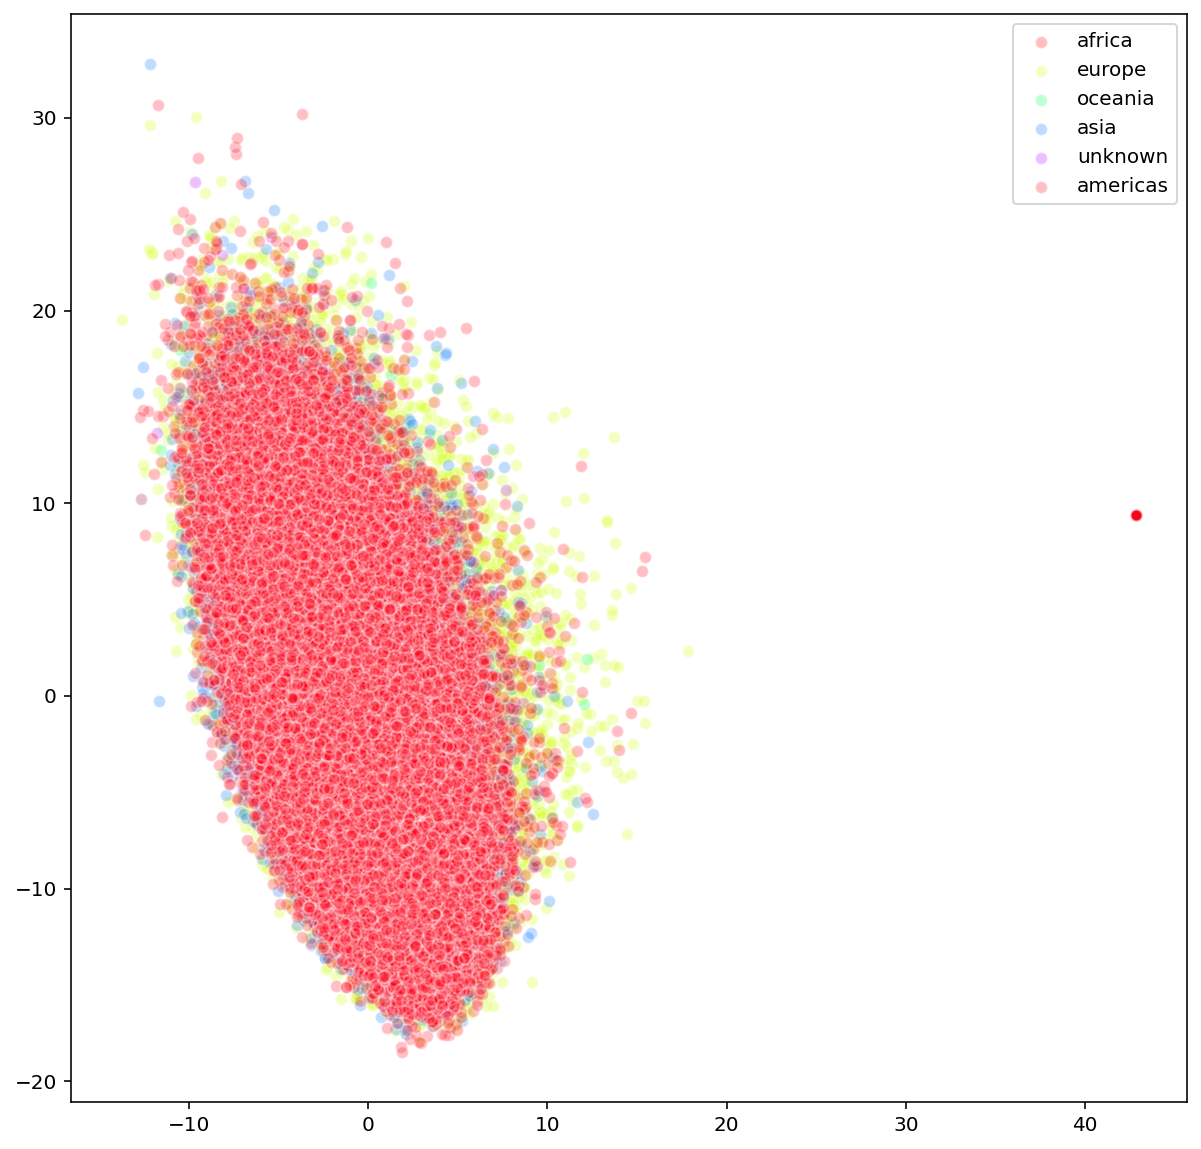

In [81]:
plot_indicator_2d(df,column_store._geography_superregion,column_store._pca_2d)

Above, we see the results of our visualization of the 2D output of the PCA dimensionality reduction. On the basis of this visualization, it seems that the data is very difficult to separate, as it offers no clearly identifiable and linearly separable clusters. Even making use of the overlay of the superregions that the datapoints belong to do not lend us a clear way to delineate the data.

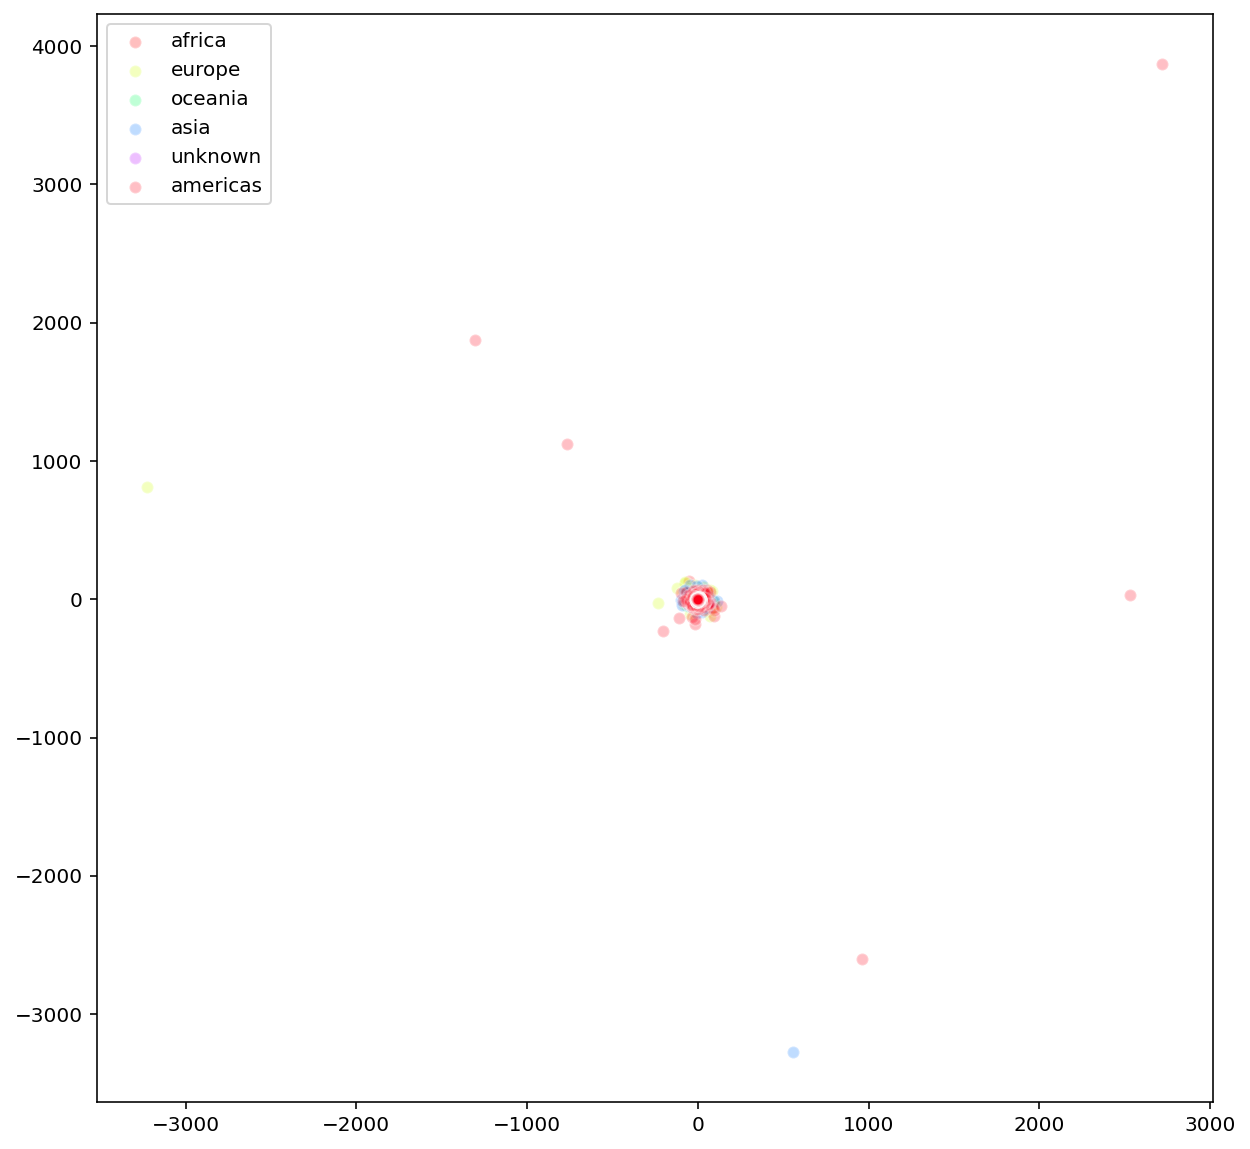

In [82]:
plot_indicator_2d(df,column_store._geography_superregion,column_store._umap_2d)

Visualizing the output from the UMAP algorithm yields very different results to PCA. As we can see from the above, UMAP generates huge outlier values that make it difficult to identify whether the algorithm is doing a better job of separating the album cover images. As such, we will apply the OutlierRemover transformer to the data and remove those rows with significant outliers, in order to get a better understanding of how UMAP is interpreting the data it was trained on.

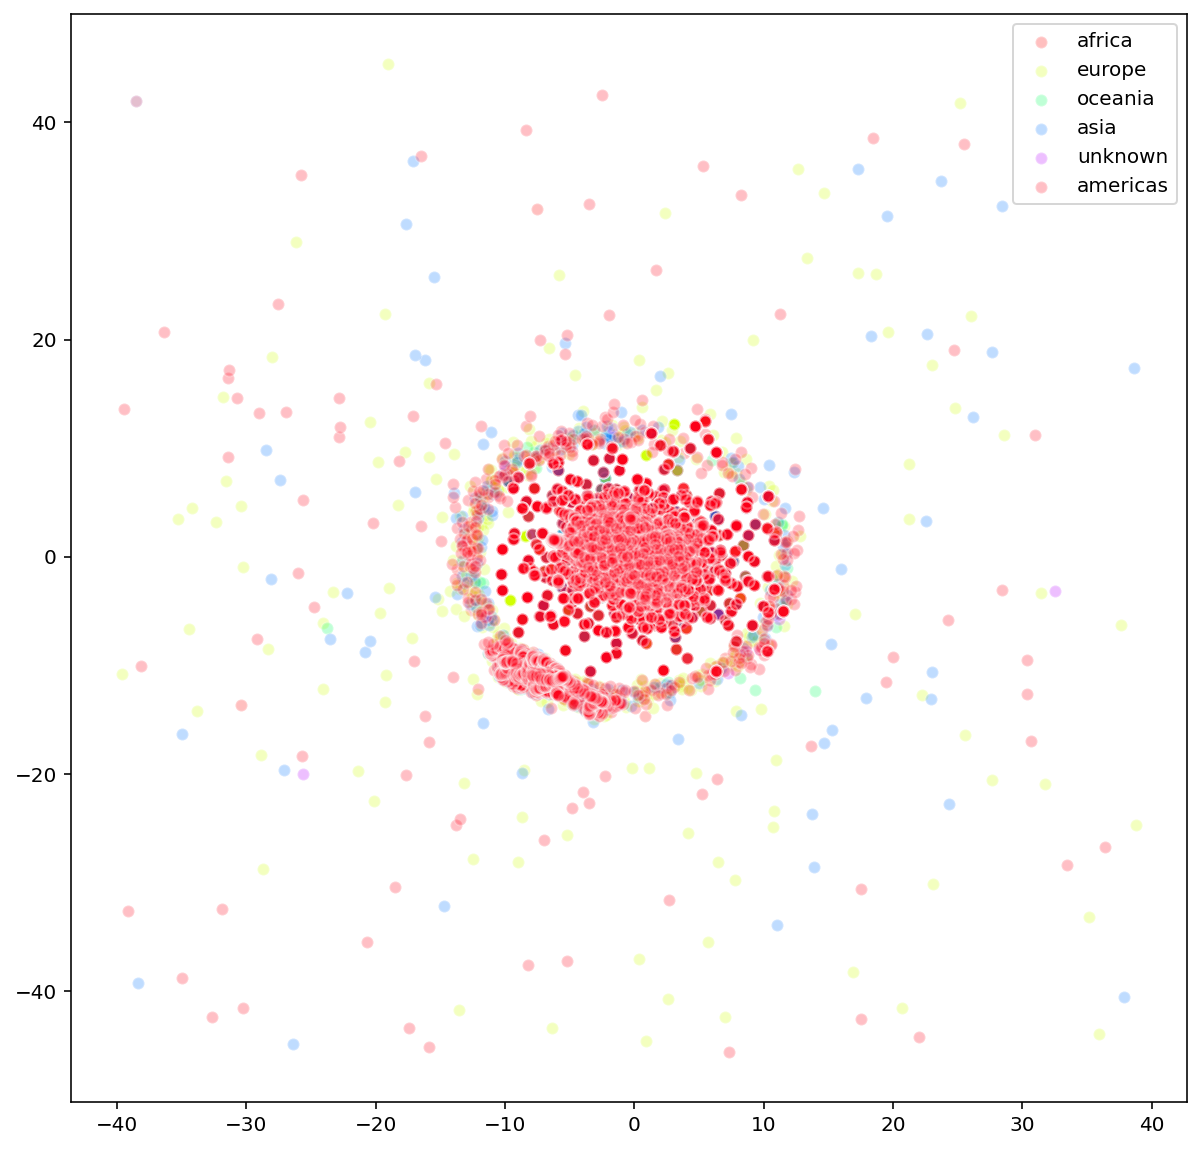

In [83]:
outlier_remover = OutlierRemover(features=column_store._umap_2d)
plot_indicator_2d(outlier_remover.fit_transform(df),column_store._geography_superregion,column_store._umap_2d)

From the above, we see that UMAP seems to be doing a better job of separating individual samples in the 2D space. Nonetheless, the majority of samples seem to be bunched together, with very little possibility to identify major clusters. 

Despite the lacking existence of clear clusters in the dimensionality reduction output data, we will attempt to overlay additional features over the visualization in order to see if any patterns can be identified which may be germane to our analysis. 

Following on from our initial visualizations, we will attempt to identify whether it is possible to cluster the dimensionality reduction output along ``market_value`` quantiles, in order to see if there are any visual cues that point towards a relationship between the information contained in the cover images of Jazz albums and their ``market_value``

In [1]:
df['market_value'].quantile([0.25,0.5,0.75,1])

NameError: name 'df' is not defined

In [2]:
def identify_quantile(x,lower,upper):
    if x >= lower and x < upper:
        return 1
    return 0

In [ ]:
for quantile in [0.25,0.5,0.75,1]:
    df['market_value_quantile_%s' % quantile] = df['market_value'].apply(identify_quantile,lower=df['market_value'].quantile(quantile-0.25),upper=df['market_value'].quantile(quantile))

In [87]:
market_value_quantiles = list(filter(lambda x: 'market_value_quantile' in x,df.columns))
df[market_value_quantiles].describe()

market_value_quantile_0.25  ...  market_value_quantile_1
count               165673.000000  ...            165673.000000
mean                     0.249353  ...                 0.250113
std                      0.432640  ...                 0.433079
min                      0.000000  ...                 0.000000
25%                      0.000000  ...                 0.000000
50%                      0.000000  ...                 0.000000
75%                      0.000000  ...                 1.000000
max                      1.000000  ...                 1.000000

[8 rows x 4 columns]

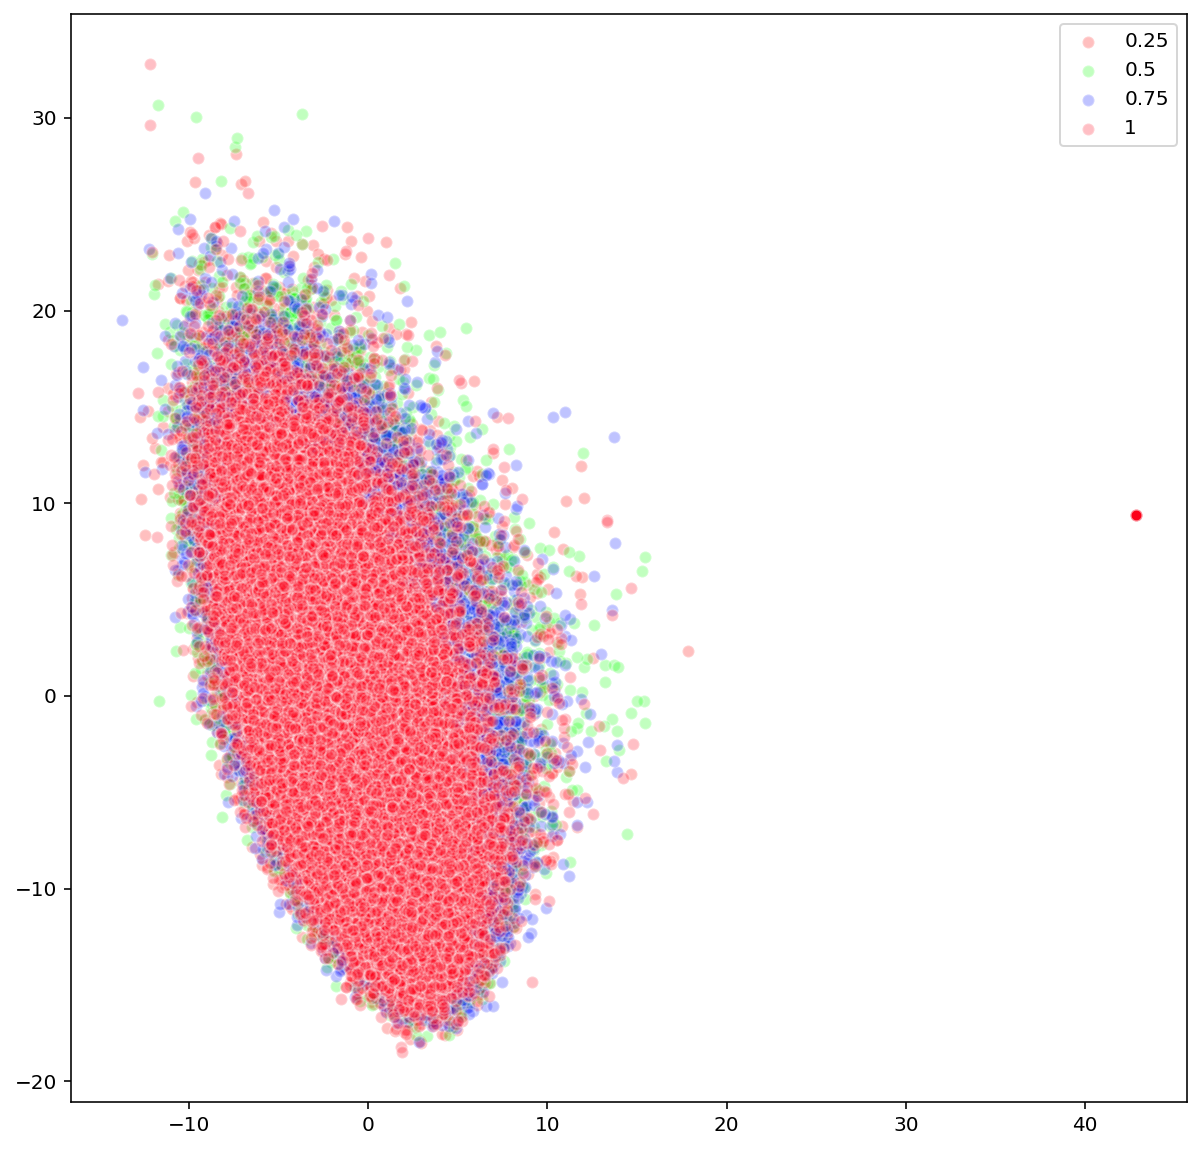

In [88]:
plot_indicator_2d(df,market_value_quantiles,column_store._pca_2d)

The above visualization of the PCA results is almost identical to our initial overlay of Jazz Album superregion. There do not appear to be any clear lines that can be drawn to separate the cover image representations of jazz albums according to their market value using this algorithm.

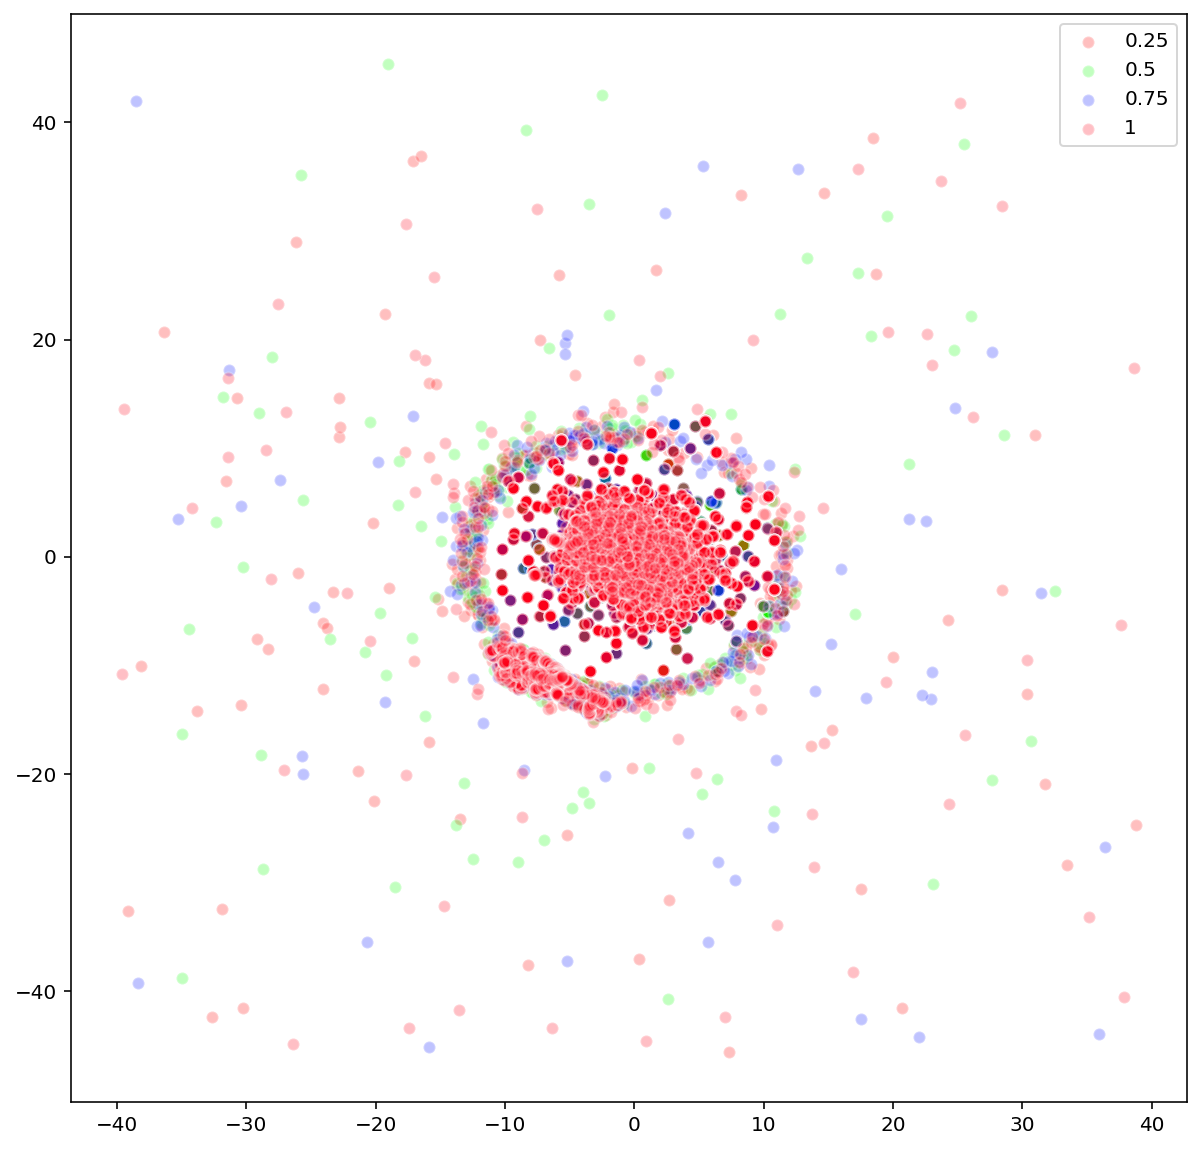

In [89]:
plot_indicator_2d(outlier_remover.fit_transform(df),market_value_quantiles,column_store._umap_2d)

Unfortunately, the results for UMAP are not much better. From the above it does not seem to be possible to organize the samples of our dataset into clusters defined by ``market_value``.

From the above visualizations of the high-level features obtained from the pre-trained computer vision model, we see that there are no clear lines to draw among the dimensionally reduced embeddings according to the target feature we are using in this analysis. While this is unfortunate, it is not completely unexpected, as cover images can vary essentially limitlessly and as such grouping them together according to market value is a difficult task. Nonetheless, we'll use these embeddings as input features for our machine learning models, after reducing the dimensions to 10. For this purpose we will use UMAP, as it seems to perform better in the 2d visualization scenario, being able to separate data points more effectively, and in less of a jammed together fashion as in the PCA examples.